
# Forest Fire Prediction Project - Exploratory Data Analysis

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook performs comprehensive exploratory data analysis on all datasets:
- Fire occurrences and their characteristics
- Land cover distribution
- Climate variables (temperature, precipitation)
- Elevation patterns
- Soil properties
- Relationships between variables



In [2]:
## 0. Import Libraries and Setup

import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.sample import sample_gen
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

# Set visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)



## 1. Fire Data Analysis

Analyzing fire occurrence patterns, distributions, and characteristics.


In [3]:
def load_and_explore_fire_data():
    """Load and perform initial exploration of fire data."""
    
    # Load fire data
    fires = pd.read_csv("../data/processed/Fire/combined_fire_data_2024.csv")
    
    print("="*70)
    print("FIRE DATA OVERVIEW")
    print("="*70)
    print(f"Shape: {fires.shape}")
    print(f"\nColumns: {list(fires.columns)}")
    print(f"\nData Types:\n{fires.dtypes}")
    print(f"\nMissing Values:\n{fires.isnull().sum()}")
    print("="*70)
    
    return fires

fires = load_and_explore_fire_data()
fires.head()

FIRE DATA OVERVIEW
Shape: (90250, 15)

Columns: ['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_ti5', 'frp', 'daynight', 'type']

Data Types:
latitude      float64
longitude     float64
bright_ti4    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite      object
instrument     object
confidence     object
version         int64
bright_ti5    float64
frp           float64
daynight       object
type            int64
dtype: object

Missing Values:
latitude      0
longitude     0
bright_ti4    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_ti5    0
frp           0
daynight      0
type          0
dtype: int64


latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  27.72818    9.87200      295.51  0.76   0.77  2024-01-01         3   
1  28.63288    9.77909      301.80  0.79   0.78  2024-01-01         3   
2  28.64012    9.77953      298.65  0.79   0.78  2024-01-01         3   
3  36.74886    6.25409      338.04  0.46   0.39  2024-01-01       141   
4  35.87978    4.44782      309.49  0.41   0.37  2024-01-01       141   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  
0       N20      VIIRS          n        2      277.66  1.24        N     2  
1       N20      VIIRS          n        2      277.05  1.57        N     2  
2       N20      VIIRS          n        2      277.04  1.34        N     2  
3       N20      VIIRS          n        2      257.28  5.21        N     2  
4       N20      VIIRS          n        2      272.08  1.58        N     2

### 1.1 Univariate Analysis - Numerical Features

Statistical Summary:
              count        mean         std        min        25%         50%  \
latitude    90250.0   31.476760    2.666477   19.60323   28.91151   31.409125   
longitude   90250.0    6.280033    2.593748   -8.11805    5.64216    6.557880   
bright_ti4  90250.0  321.091793   18.205551  240.17000  305.38000  316.710000   
scan        90250.0    0.475991    0.101596    0.32000    0.40000    0.450000   
track       90250.0    0.515446    0.126508    0.36000    0.39000    0.490000   
acq_time    90250.0  380.331623  480.710563    0.00000   59.00000  140.000000   
bright_ti5  90250.0  291.726092   11.700269  244.79000  282.90000  290.790000   
frp         90250.0    3.447776    5.222111    0.06000    1.15000    2.060000   
type        90250.0    1.690936    0.735207    0.00000    2.00000    2.000000   

                   75%         max  
latitude     32.560313    37.32346  
longitude     8.083758    11.11035  
bright_ti4  337.400000   367.00000  
scan          0.5400

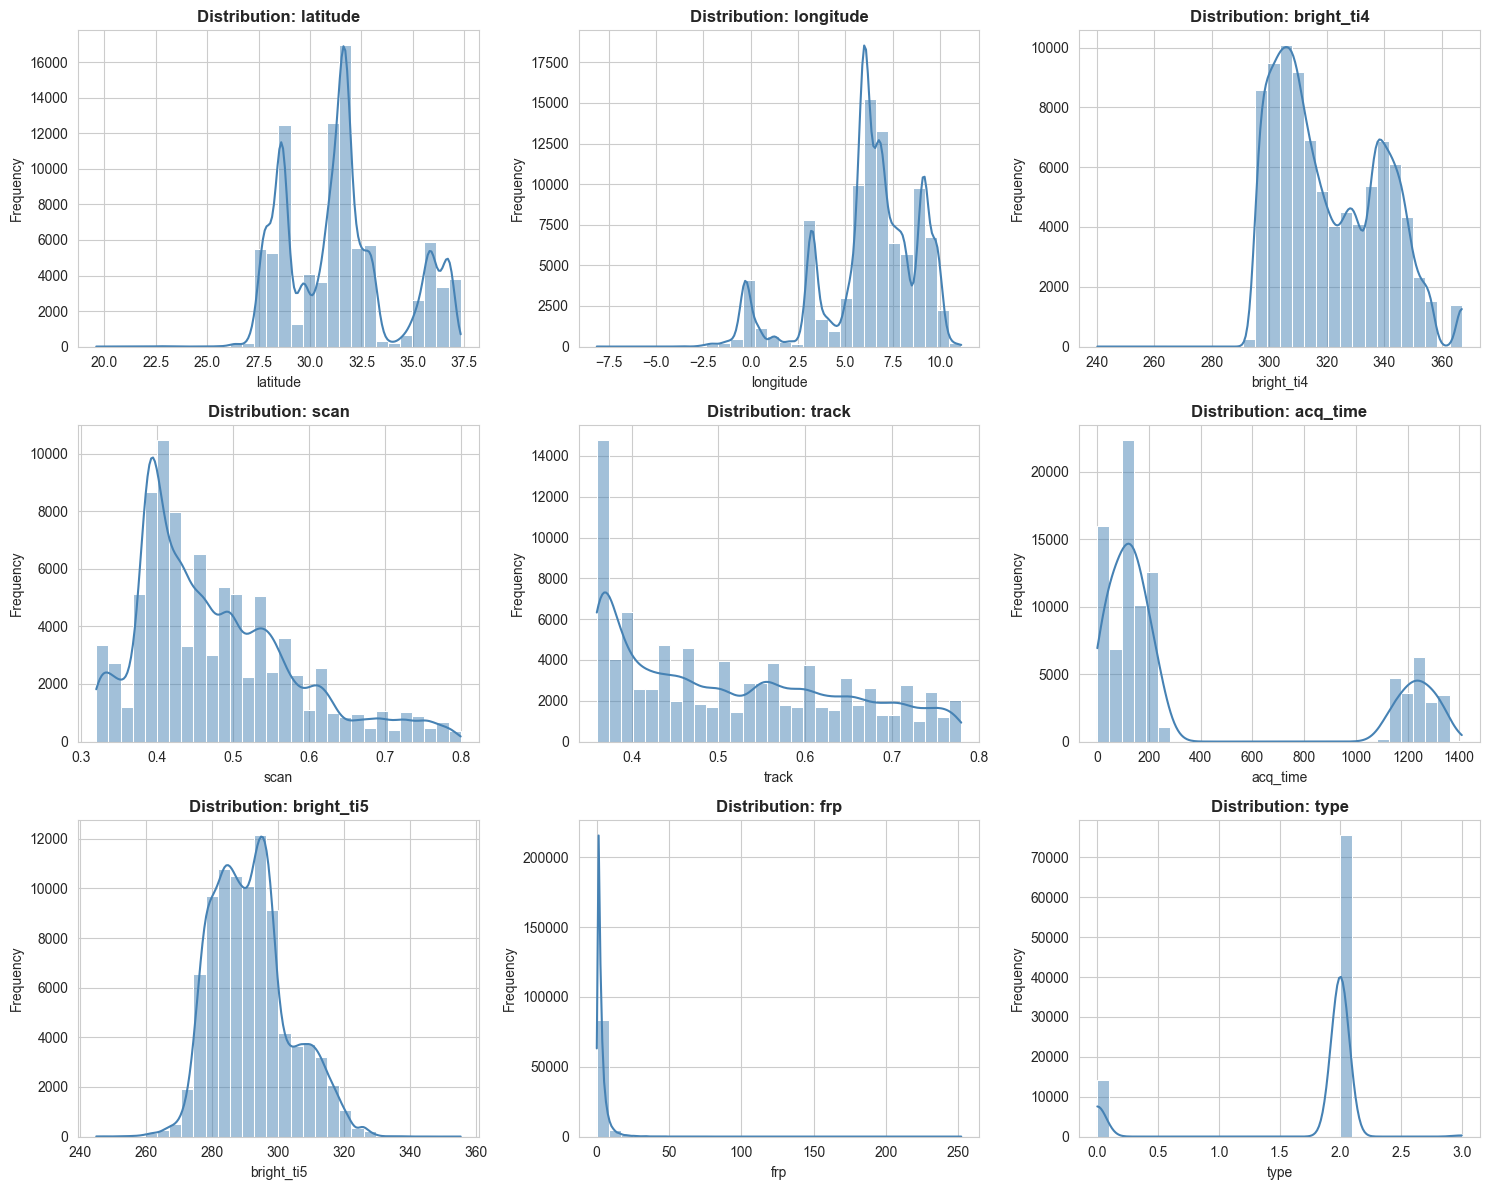

In [4]:

def analyze_numerical_features(df):
    """Analyze distribution of numerical features."""
    
    # Select numerical columns (excluding version)
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = [col for col in numeric_cols if col not in ['version']]
    
    # Statistical summary
    print("Statistical Summary:")
    print(df[numeric_cols].describe().T)
    
    # Histograms with KDE
    n_cols = len(numeric_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows*4))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[idx], color='steelblue')
        axes[idx].set_title(f'Distribution: {col}', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
    
    # Hide unused subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return numeric_cols

numeric_features = analyze_numerical_features(fires)


### 1.2 Outlier Detection

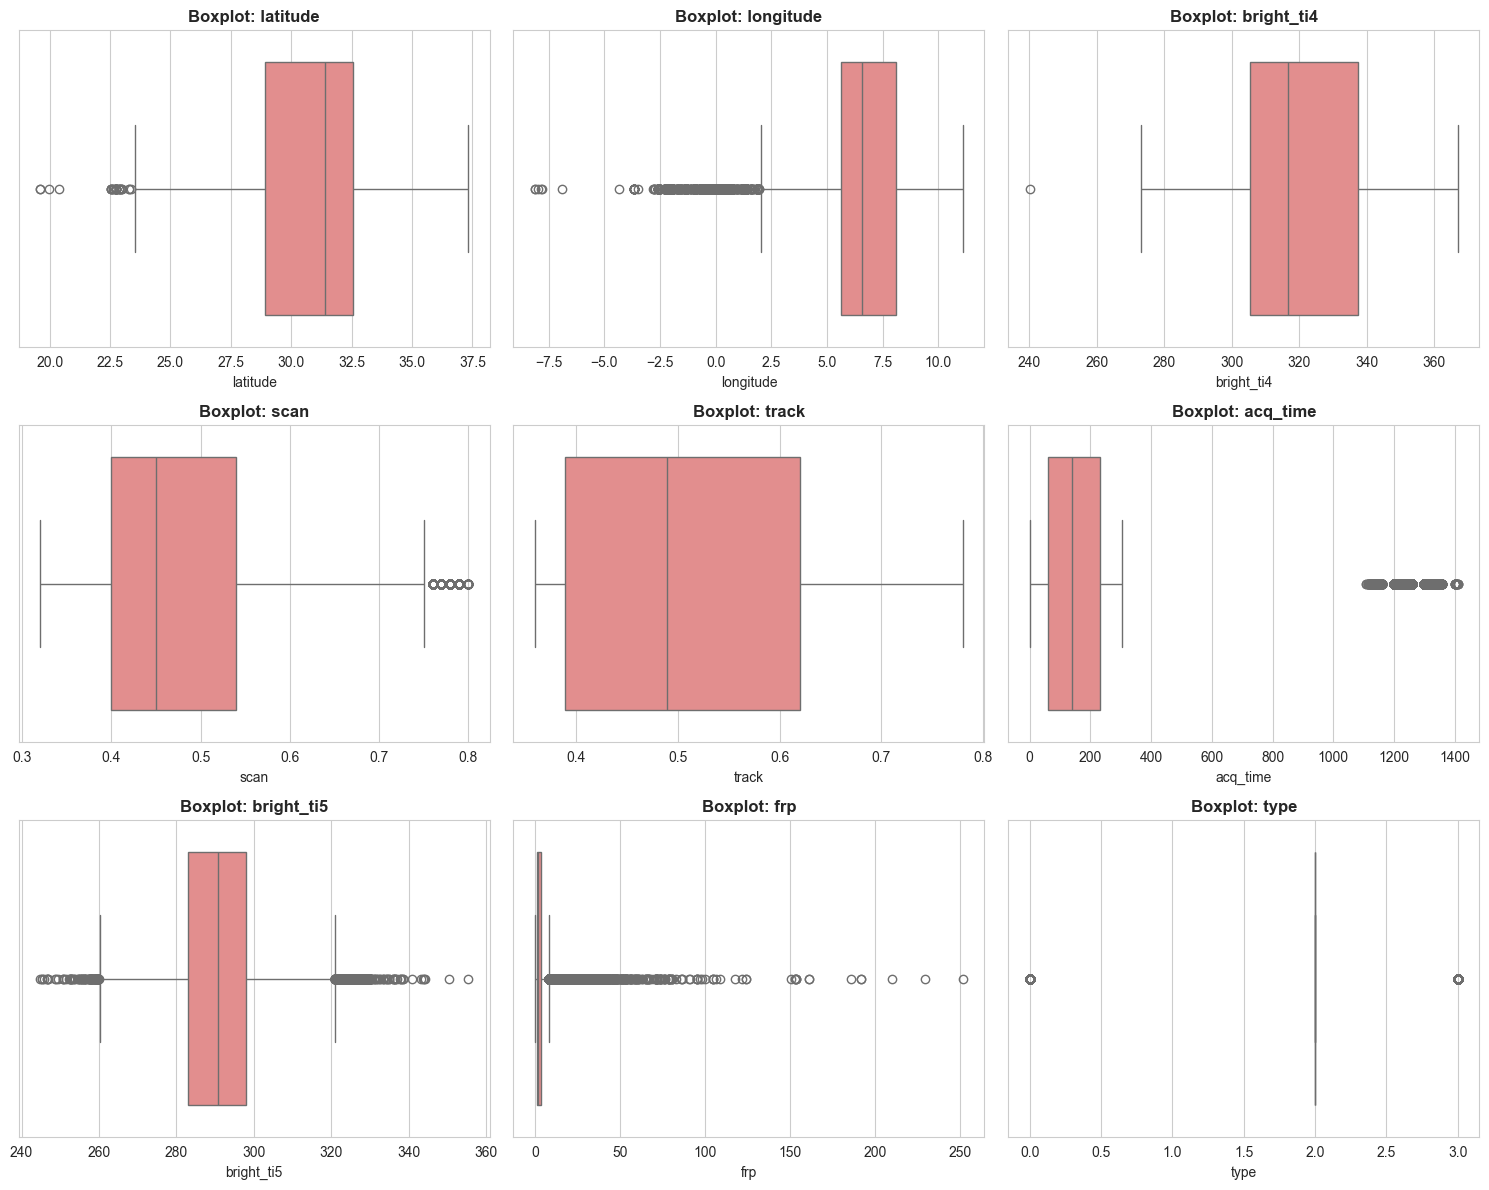

In [5]:
def detect_outliers(df, numeric_cols):
    """Visualize outliers using boxplots."""
    
    n_cols = len(numeric_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows*4))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols):
        sns.boxplot(x=df[col], ax=axes[idx], color='lightcoral')
        axes[idx].set_title(f'Boxplot: {col}', fontweight='bold')
        axes[idx].set_xlabel(col)
    
    # Hide unused subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

detect_outliers(fires, numeric_features)


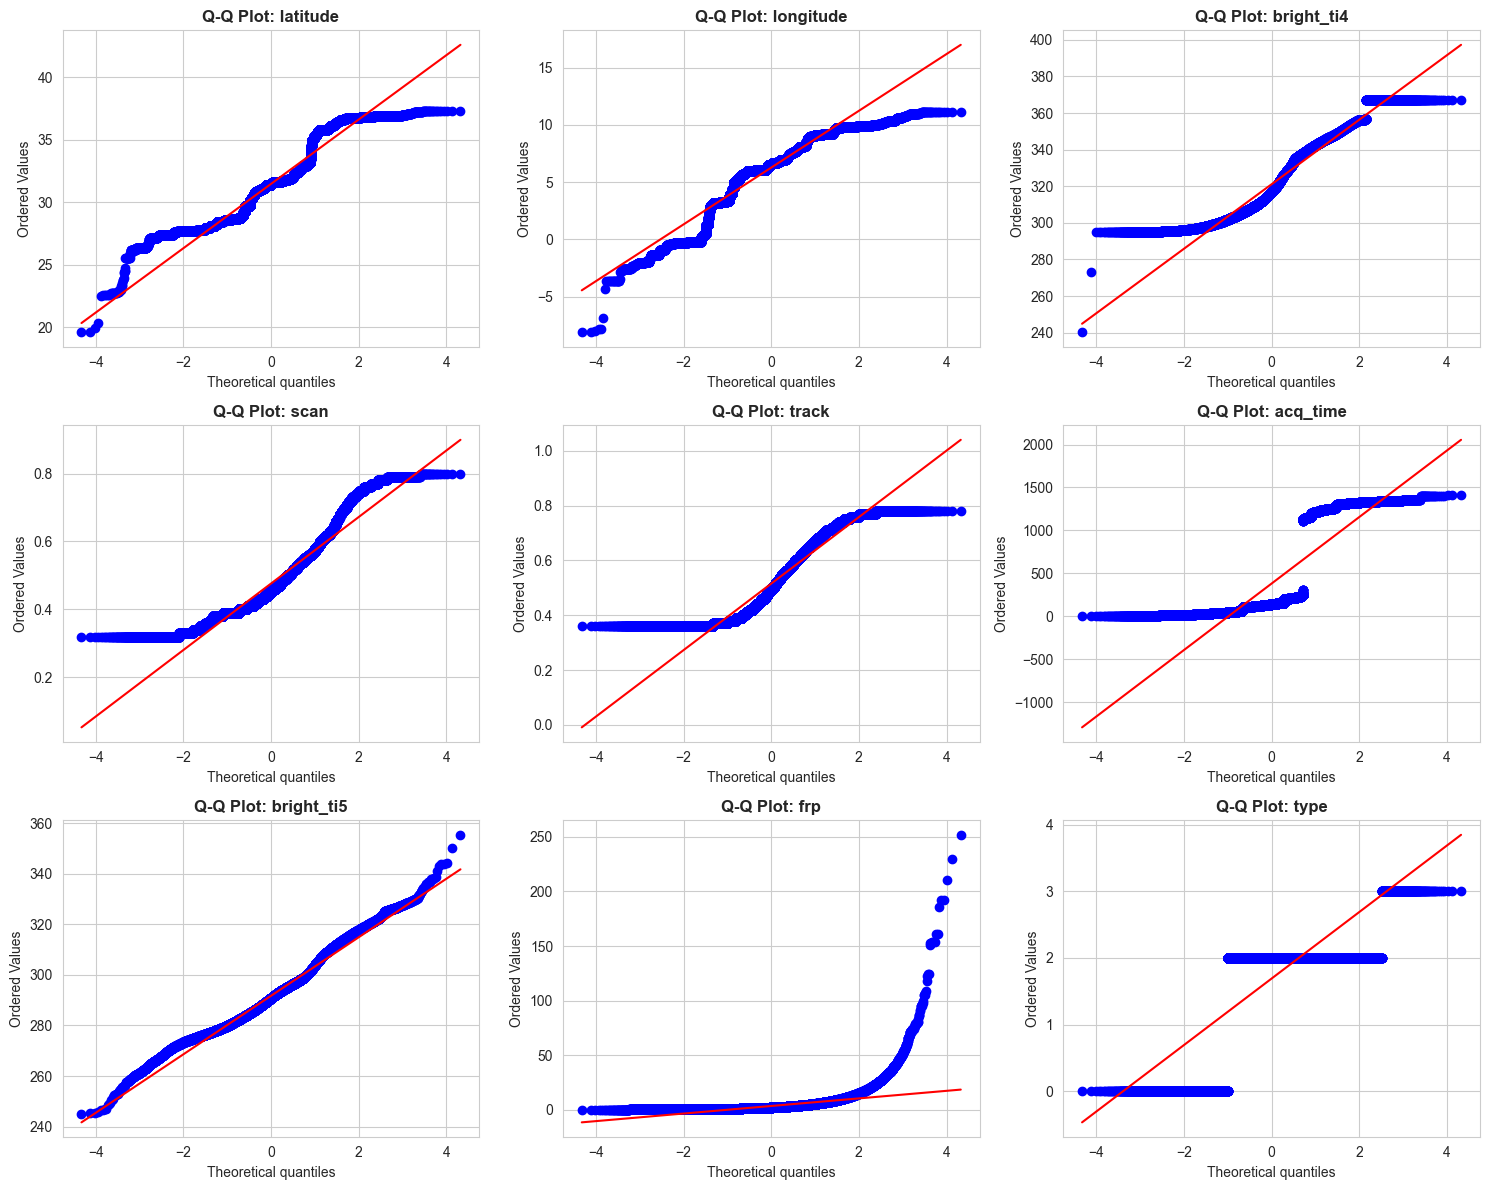

In [6]:

## 1.3 Normality Assessment

def assess_normality(df, numeric_cols):
    """Generate Q-Q plots to assess normality."""
    
    n_cols = len(numeric_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows*4))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols):
        stats.probplot(df[col].dropna(), dist="norm", plot=axes[idx])
        axes[idx].set_title(f'Q-Q Plot: {col}', fontweight='bold')
    
    # Hide unused subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

assess_normality(fires, numeric_features)


Categorical Features Summary:

satellite: ['N20']
Value counts:
satellite
N20    90250
Name: count, dtype: int64

instrument: ['VIIRS']
Value counts:
instrument
VIIRS    90250
Name: count, dtype: int64

confidence: ['n' 'h' 'l']
Value counts:
confidence
n    84128
l     5013
h     1109
Name: count, dtype: int64

daynight: ['N' 'D']
Value counts:
daynight
N    68979
D    21271
Name: count, dtype: int64

type: [2 0 3]
Value counts:
type
2    75495
0    14216
3      539
Name: count, dtype: int64


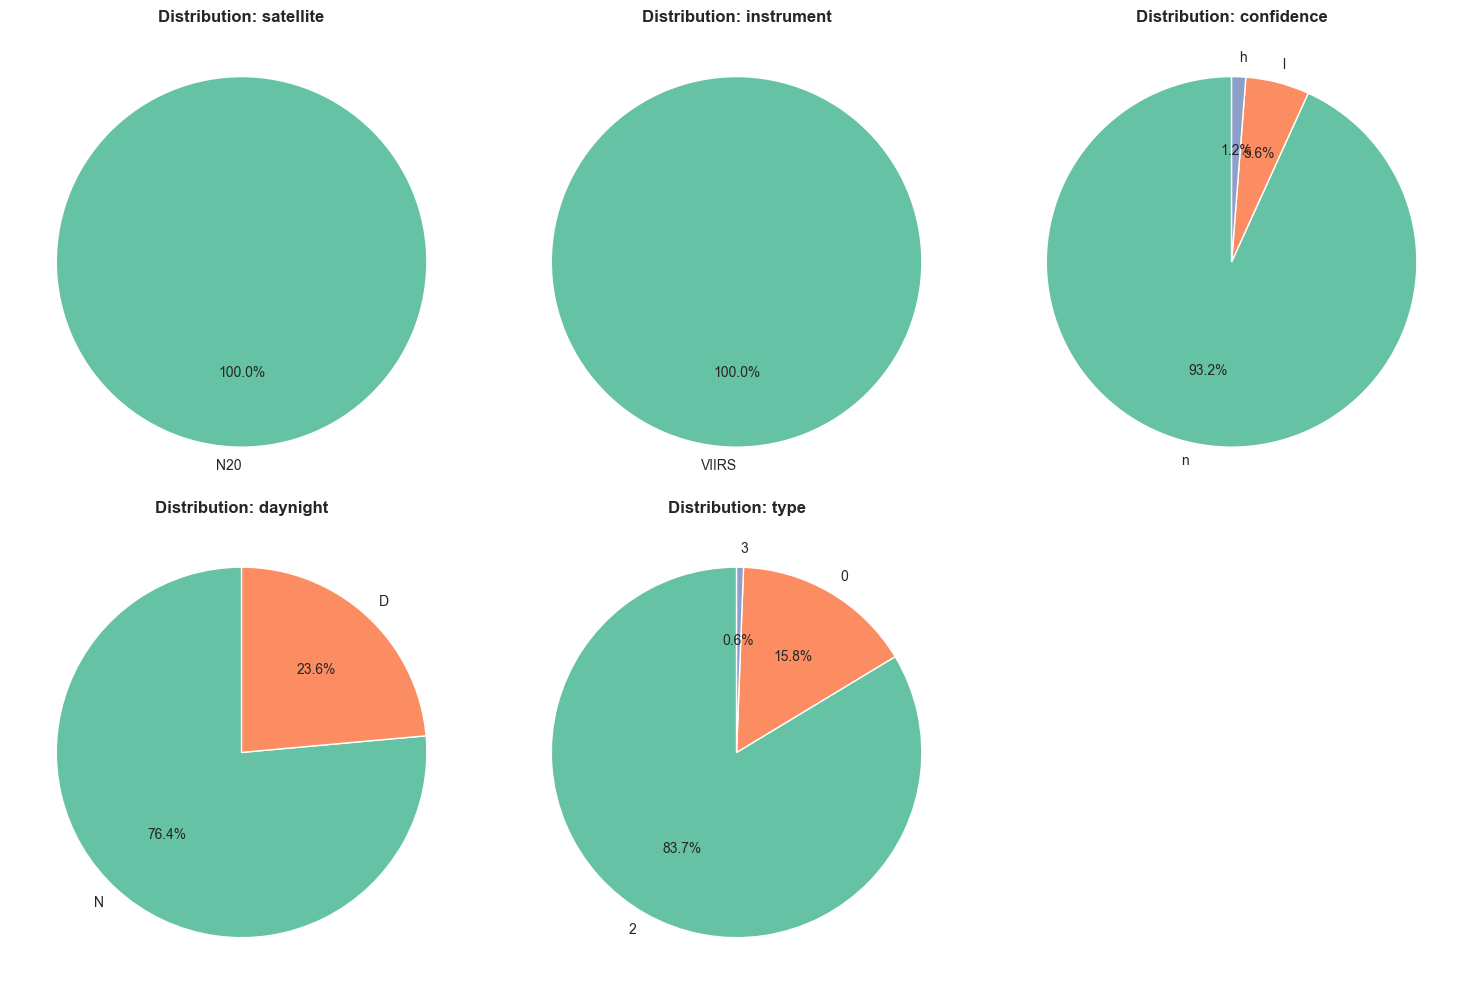

In [7]:

## 1.4 Categorical Features Analysis

def analyze_categorical_features(df):
    """Analyze categorical features distribution."""
    
    categorical_cols = ['satellite', 'instrument', 'confidence', 'daynight', 'type']
    
    # Print unique values
    print("Categorical Features Summary:")
    print("="*70)
    for col in categorical_cols:
        print(f"\n{col}: {df[col].unique()}")
        print(f"Value counts:\n{df[col].value_counts()}")
    print("="*70)
    
    # Pie charts
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_cols):
        df[col].value_counts().plot.pie(
            ax=axes[idx],
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('Set2')
        )
        axes[idx].set_title(f'Distribution: {col}', fontweight='bold')
        axes[idx].set_ylabel('')
    
    # Hide unused subplot
    axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()

analyze_categorical_features(fires)

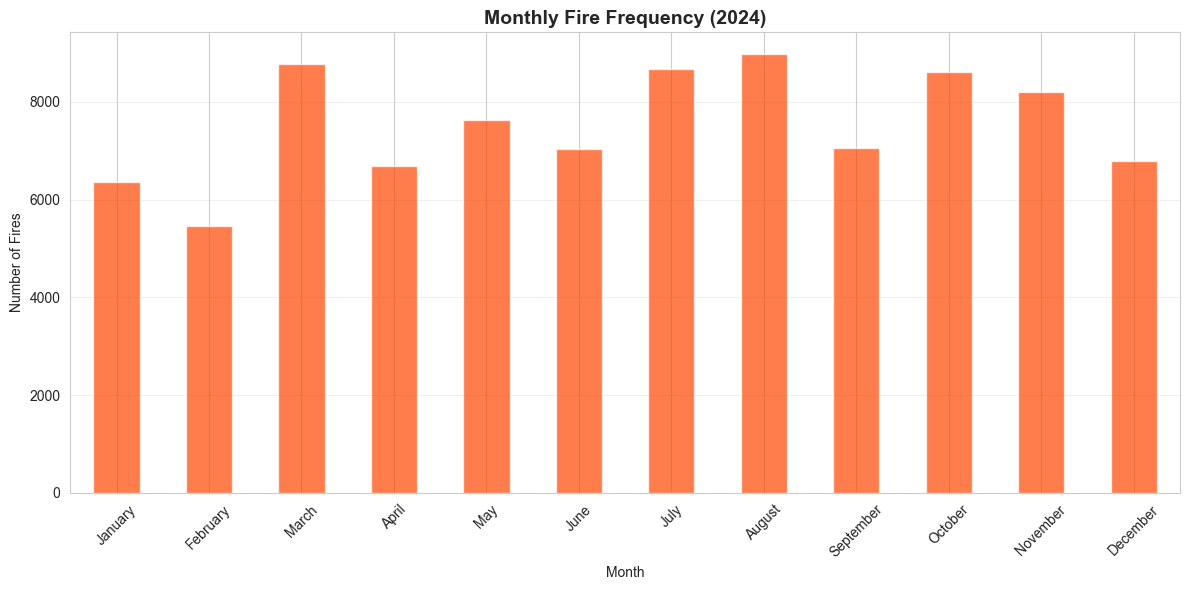

Monthly Fire Statistics:
count      12.000000
mean     7520.833333
std      1126.902338
min      5469.000000
25%      6760.500000
50%      7337.000000
75%      8630.250000
max      8973.000000
dtype: float64


In [8]:

# 1.5 Temporal Analysis

def temporal_analysis(df):
    """Analyze temporal patterns in fire occurrences."""
    
    # Convert date to datetime
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    df['month'] = df['acq_date'].dt.month
    df['month_name'] = df['acq_date'].dt.month_name()
    
    # Monthly frequency
    monthly_counts = df.groupby('month_name').size().reindex([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    monthly_counts.plot(kind='bar', ax=ax, color='orangered', alpha=0.7)
    ax.set_title('Monthly Fire Frequency (2024)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Fires')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Monthly Fire Statistics:")
    print(monthly_counts.describe())
    
    return df

fires = temporal_analysis(fires)


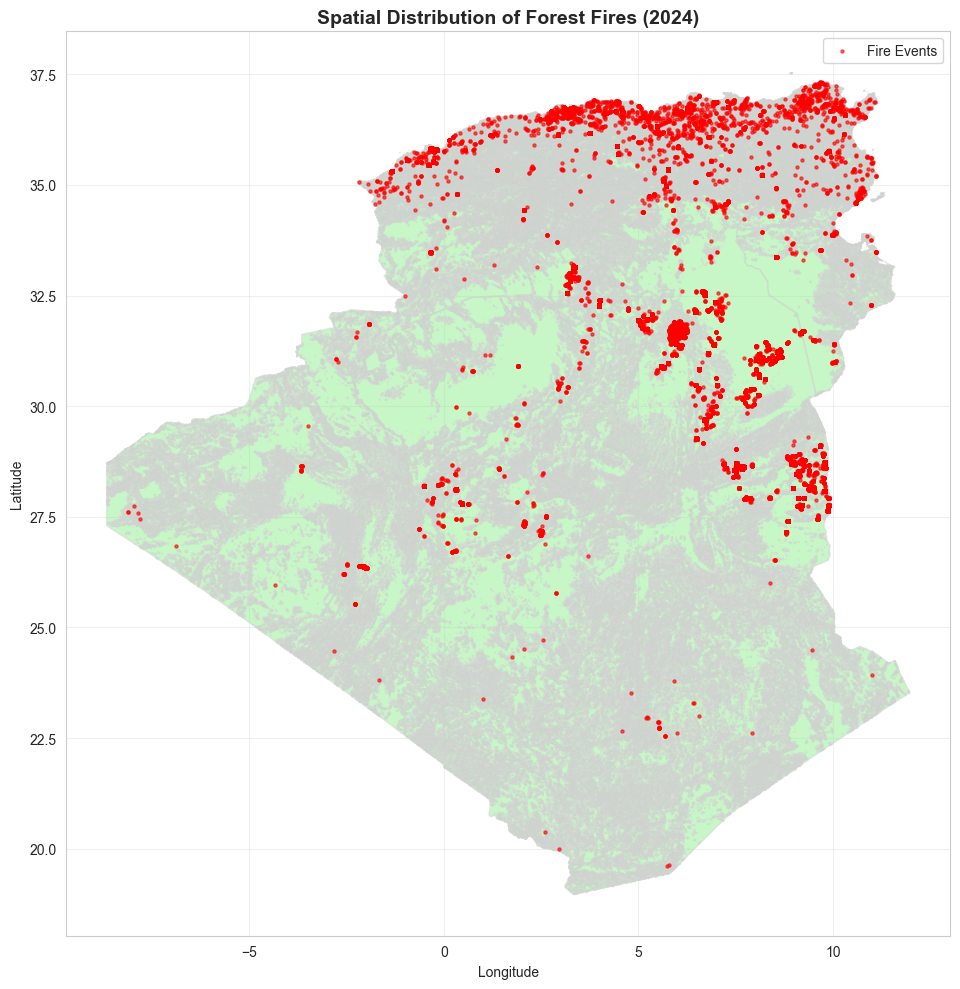

In [20]:

## 1.6 Spatial Distribution

def spatial_fire_analysis(fires_csv, shapefile_path):
    """Visualize spatial distribution of fires."""
    
    # Load data
    df = pd.read_csv(fires_csv)
    gdf_fires = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )
    gdf_landcover = gpd.read_file(shapefile_path)
    
    # Reproject if necessary
    if gdf_fires.crs != gdf_landcover.crs:
        gdf_fires = gdf_fires.to_crs(gdf_landcover.crs)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 10))
    gdf_landcover.plot(ax=ax, color='lightgreen', edgecolor='lightgray', alpha=0.5)
    gdf_fires.plot(ax=ax, color='red', markersize=5, alpha=0.6, label='Fire Events')
    
    ax.set_title('Spatial Distribution of Forest Fires (2024)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

fires_csv = "../data/processed/Fire/combined_fire_data_2024.csv"
shapefile = "../data/raw/Land Cover/combined/combined_landcover.shp"
spatial_fire_analysis(fires_csv, shapefile)


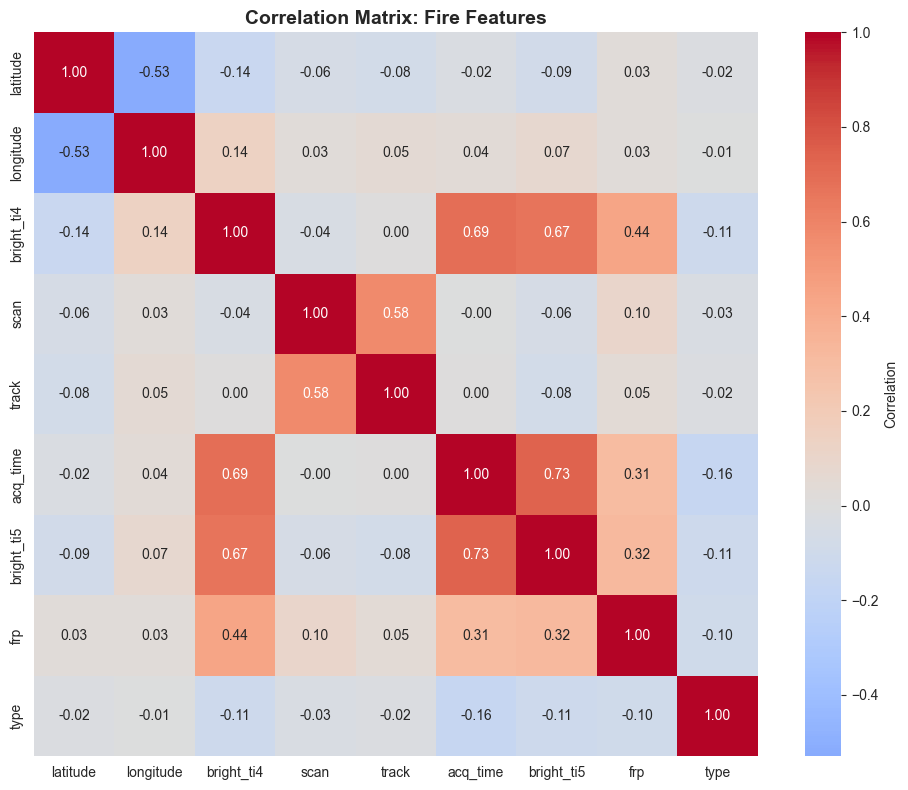


Highly Correlated Feature Pairs (|r| > 0.5):
  • latitude vs longitude: -0.529
  • bright_ti4 vs acq_time: 0.688
  • bright_ti4 vs bright_ti5: 0.669
  • scan vs track: 0.575
  • acq_time vs bright_ti5: 0.734


In [13]:

## 1.7 Correlation Analysis

def fire_correlation_analysis(df, numeric_cols):
    """Analyze correlations between fire features."""
    
    # Correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('Correlation Matrix: Fire Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Scatter plot for highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.5:
                high_corr_pairs.append((corr_matrix.columns[i], 
                                       corr_matrix.columns[j], 
                                       corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\nHighly Correlated Feature Pairs (|r| > 0.5):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  • {feat1} vs {feat2}: {corr:.3f}")

fire_correlation_analysis(fires, numeric_features)


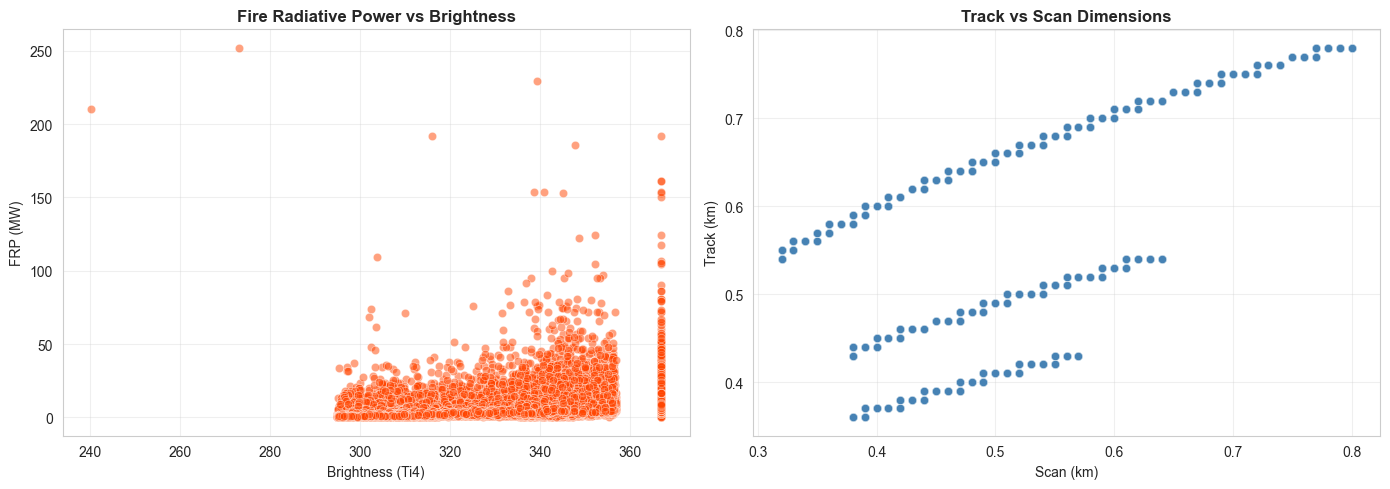

In [12]:
## 1.8 Feature Relationships

def plot_feature_relationships(df):
    """Visualize relationships between selected features."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Brightness vs FRP
    sns.scatterplot(data=df, x='bright_ti4', y='frp', alpha=0.5, 
                   color='orangered', ax=axes[0])
    axes[0].set_title('Fire Radiative Power vs Brightness', fontweight='bold')
    axes[0].set_xlabel('Brightness (Ti4)')
    axes[0].set_ylabel('FRP (MW)')
    axes[0].grid(True, alpha=0.3)
    
    # Scan vs Track
    sns.scatterplot(data=df, x='scan', y='track', alpha=0.5, 
                   color='steelblue', ax=axes[1])
    axes[1].set_title('Track vs Scan Dimensions', fontweight='bold')
    axes[1].set_xlabel('Scan (km)')
    axes[1].set_ylabel('Track (km)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_feature_relationships(fires)


## 2. Land Cover Analysis

In [16]:

# Analyzing land cover types and their spatial distribution.

def analyze_landcover():
    """Load and analyze land cover data."""
    
    # Load shapefile
    landcover = gpd.read_file("../data/raw/Land Cover/combined/combined_landcover.shp")
    
    # Convert to WGS84 if needed
    if landcover.crs.to_epsg() != 4326:
        landcover = landcover.to_crs(epsg=4326)
    
    print("="*70)
    print("LAND COVER DATA OVERVIEW")
    print("="*70)
    print(f"Shape: {landcover.shape}")
    print(f"CRS: {landcover.crs}")
    print(f"Bounds: {landcover.total_bounds}")
    print(f"\nColumns: {list(landcover.columns)}")
    print(f"\nUnique GRIDCODE values: {landcover['GRIDCODE'].nunique()}")
    print(f"\nMissing values:\n{landcover.isnull().sum()}")
    print("="*70)
    
    return landcover

landcover = analyze_landcover()
landcover.head()

LAND COVER DATA OVERVIEW
Shape: (438513, 7)
CRS: EPSG:4326
Bounds: [-8.67386723 18.96002769 11.97954845 37.54393005]

Columns: ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'AREA_M2', 'LCCCode_1', 'geometry']

Unique GRIDCODE values: 22

Missing values:
ID                0
GRIDCODE          0
AREA          52059
LCCCODE       52059
AREA_M2      386454
LCCCode_1    386454
geometry          0
dtype: int64


ID  GRIDCODE          AREA       LCCCODE  AREA_M2 LCCCode_1  \
0   4       210  6.228187e+06  7001 // 8001      NaN      None   
1   2       210  6.242408e+06  7001 // 8001      NaN      None   
2   1       210  1.482995e+06  7001 // 8001      NaN      None   
3   8        50  4.590841e+08  21497-121340      NaN      None   
4  13       210  6.371533e+06  7001 // 8001      NaN      None   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...

Land Cover Type Distribution:
GRIDCODE
14      14872
16        550
20      31891
30      24856
41          8
50       2575
70        818
100        49
110     16002
120       405
130      8248
134      5432
140         1
150     47560
151     24520
170         6
190       145
200    172221
201     61857
202     25951
203         8
210       538
Name: count, dtype: int64

Area Summary by Land Cover Type:
           count  total_area_km2
GRIDCODE                        
200       172221    38378.771791
202        25951    37535.099205
150        47560    16714.281105
151        24520    12718.067923
201        61857    12708.757719
30         24856    11704.767024
20         31891    10692.406680
14         14872     8039.823197
110        16002     2333.275524
210          538     1367.082829
190          145     1314.557525
50          2575      775.861772
130         8248      586.687815
134         5432      127.572822
16           550      121.835332
203            8       50.557015

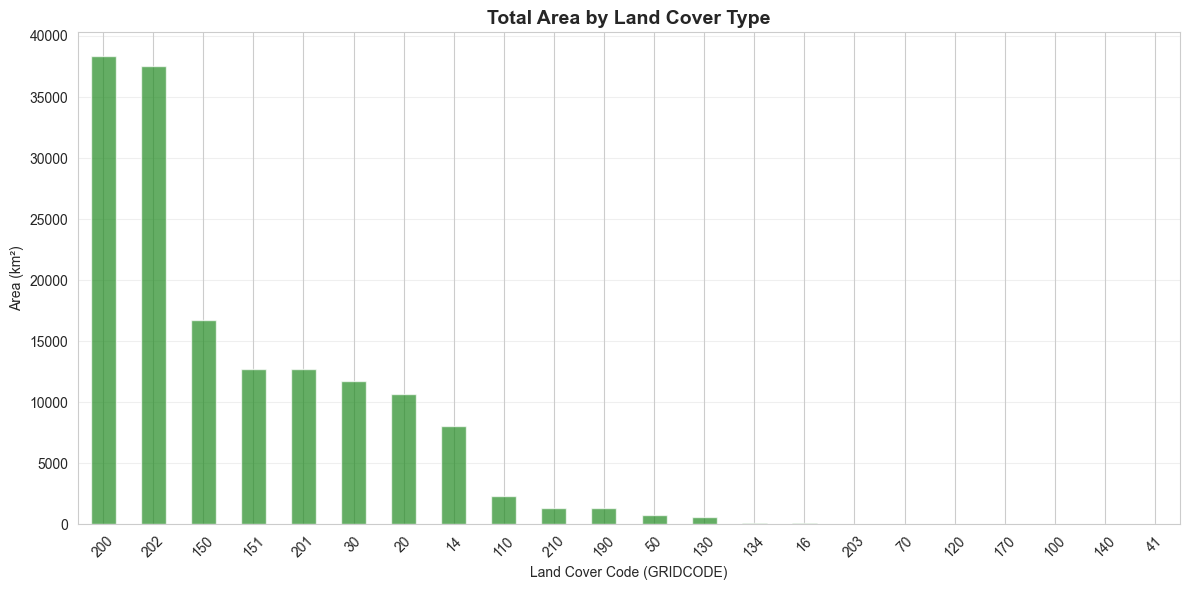

In [17]:


## 2.1 Land Cover Distribution

def landcover_distribution(gdf):
    """Analyze land cover type distribution."""
    
    # Value counts
    lc_counts = gdf['GRIDCODE'].value_counts().sort_index()
    print("Land Cover Type Distribution:")
    print(lc_counts)
    
    # Summary by GRIDCODE
    summary = gdf.groupby('GRIDCODE').agg(
        count=('GRIDCODE', 'count'),
        total_area_km2=('AREA_M2', lambda x: x.sum() / 1e6)
    ).sort_values(by='total_area_km2', ascending=False)
    
    print("\nArea Summary by Land Cover Type:")
    print(summary)
    
    # Bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    summary['total_area_km2'].plot(kind='bar', ax=ax, color='forestgreen', alpha=0.7)
    ax.set_title('Total Area by Land Cover Type', fontsize=14, fontweight='bold')
    ax.set_xlabel('Land Cover Code (GRIDCODE)')
    ax.set_ylabel('Area (km²)')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

landcover_distribution(landcover)

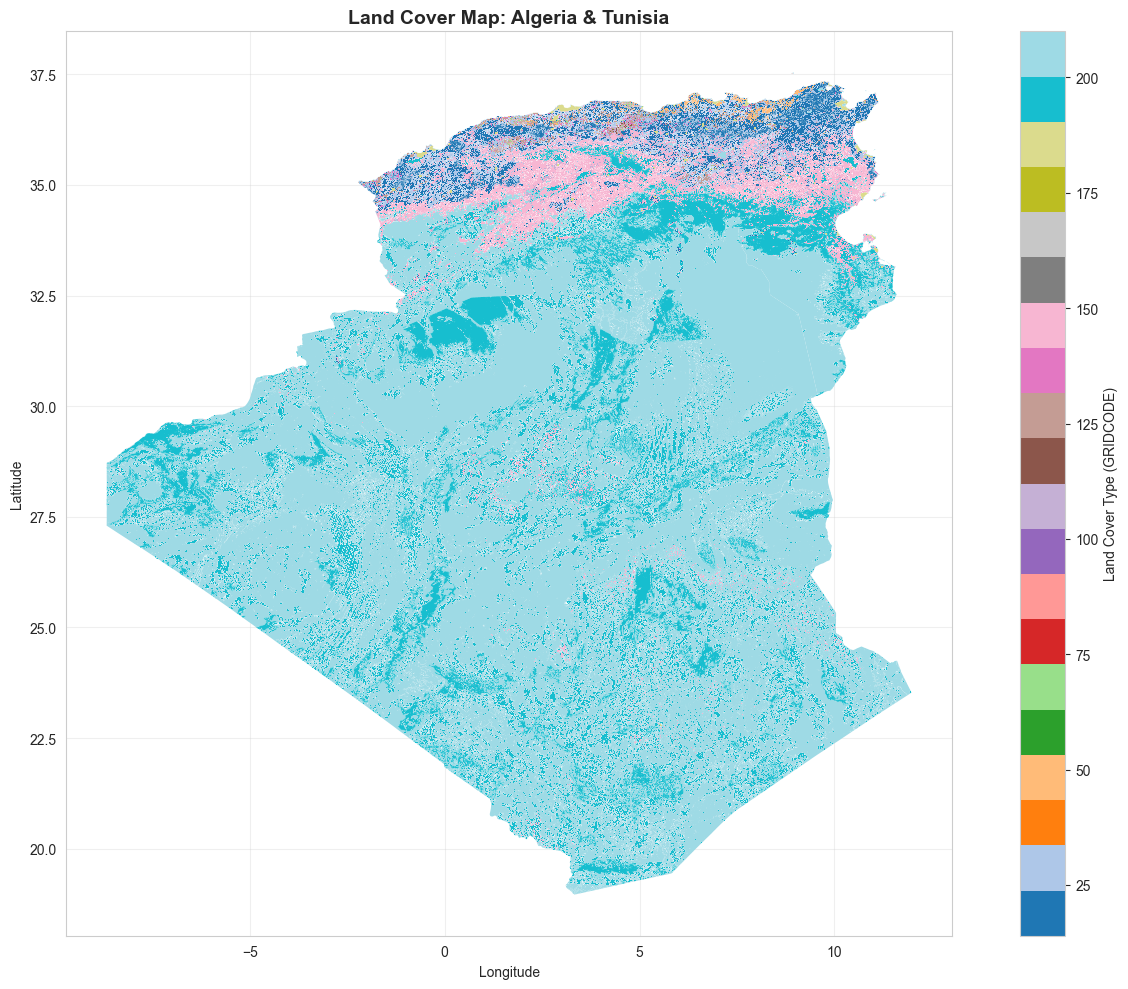

In [18]:


## 2.2 Land Cover Map Visualization

def visualize_landcover(gdf):
    """Create land cover map."""
    
    fig, ax = plt.subplots(figsize=(14, 10))
    gdf.plot(column='GRIDCODE', ax=ax, legend=True, cmap='tab20',
             edgecolor='none', legend_kwds={'label': 'Land Cover Type (GRIDCODE)'})
    ax.set_title('Land Cover Map: Algeria & Tunisia', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_landcover(landcover)



## 3. Climate Data Analysis

In [19]:

# Analyzing temperature and precipitation patterns.

def load_climate_rasters():
    """Load climate raster data."""
    
    # Example files (adjust month as needed)
    prec_path = "../data/processed/Climate/wc2.1_cruts4.09_5m_prec_2024-01_clipped.tif"
    tmax_path = "../data/processed/Climate/wc2.1_cruts4.09_5m_tmax_2024-01_clipped.tif"
    tmin_path = "../data/processed/Climate/wc2.1_cruts4.09_5m_tmin_2024-01_clipped.tif"
    
    # Open datasets
    prec_ds = rasterio.open(prec_path)
    tmax_ds = rasterio.open(tmax_path)
    tmin_ds = rasterio.open(tmin_path)
    
    print("="*70)
    print("CLIMATE DATA OVERVIEW")
    print("="*70)
    print(f"Precipitation CRS: {prec_ds.crs}")
    print(f"Temperature CRS: {tmax_ds.crs}")
    print(f"Raster shape: {prec_ds.shape}")
    print("="*70)
    
    return prec_ds, tmax_ds, tmin_ds

prec_ds, tmax_ds, tmin_ds = load_climate_rasters()


CLIMATE DATA OVERVIEW
Precipitation CRS: EPSG:4326
Temperature CRS: EPSG:4326
Raster shape: (224, 249)


In [21]:

## 3.1 Climate Variable Statistics

def analyze_climate_statistics(prec_ds, tmax_ds, tmin_ds):
    """Compute and display climate statistics."""
    
    # Read data
    prec = prec_ds.read(1)
    tmax = tmax_ds.read(1)
    tmin = tmin_ds.read(1)
    
    # Replace nodata with NaN
    prec = np.where(prec == prec_ds.nodata, np.nan, prec)
    tmax = np.where(tmax == tmax_ds.nodata, np.nan, tmax)
    tmin = np.where(tmin == tmin_ds.nodata, np.nan, tmin)
    
    # Statistics
    climate_stats = pd.DataFrame({
        'Variable': ['Precipitation (mm)', 'Tmax (°C)', 'Tmin (°C)'],
        'Min': [np.nanmin(prec), np.nanmin(tmax), np.nanmin(tmin)],
        'Max': [np.nanmax(prec), np.nanmax(tmax), np.nanmax(tmin)],
        'Mean': [np.nanmean(prec), np.nanmean(tmax), np.nanmean(tmin)],
        'Std': [np.nanstd(prec), np.nanstd(tmax), np.nanstd(tmin)]
    })
    
    print("Climate Variable Statistics:")
    print(climate_stats.to_string(index=False))
    
    return prec, tmax, tmin

prec, tmax, tmin = analyze_climate_statistics(prec_ds, tmax_ds, tmin_ds)

Climate Variable Statistics:
          Variable   Min     Max      Mean       Std
Precipitation (mm)  0.00 139.125  4.306724 10.338276
         Tmax (°C)  6.25  28.000 20.350985  3.293986
         Tmin (°C) -1.50  11.000  5.668147  2.110691


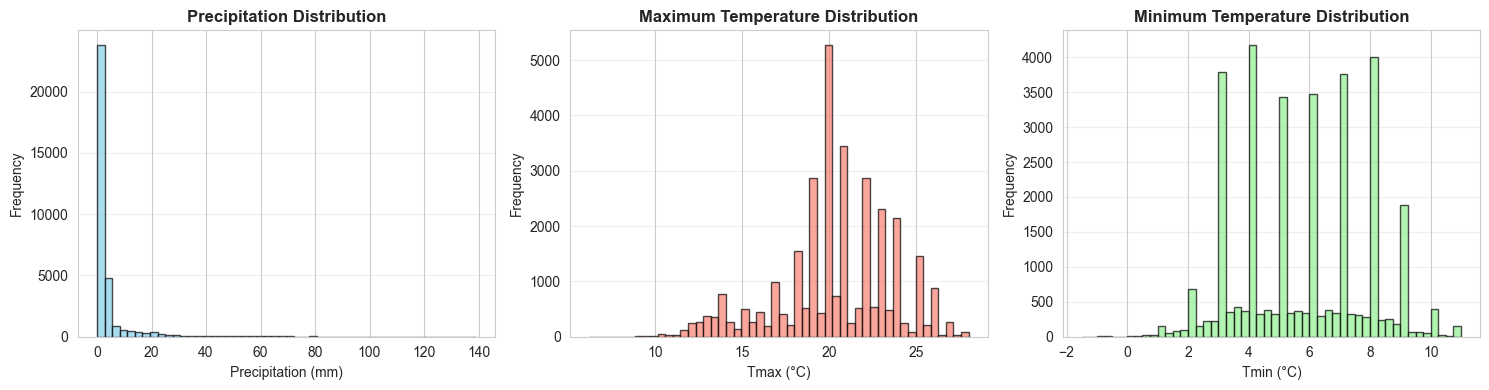

In [22]:

## 3.2 Climate Variable Distributions

def plot_climate_distributions(prec, tmax, tmin):
    """Visualize climate variable distributions."""
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Precipitation
    axes[0].hist(prec.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Precipitation Distribution', fontweight='bold')
    axes[0].set_xlabel('Precipitation (mm)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Tmax
    axes[1].hist(tmax.flatten(), bins=50, color='salmon', edgecolor='black', alpha=0.7)
    axes[1].set_title('Maximum Temperature Distribution', fontweight='bold')
    axes[1].set_xlabel('Tmax (°C)')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Tmin
    axes[2].hist(tmin.flatten(), bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[2].set_title('Minimum Temperature Distribution', fontweight='bold')
    axes[2].set_xlabel('Tmin (°C)')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_climate_distributions(prec, tmax, tmin)


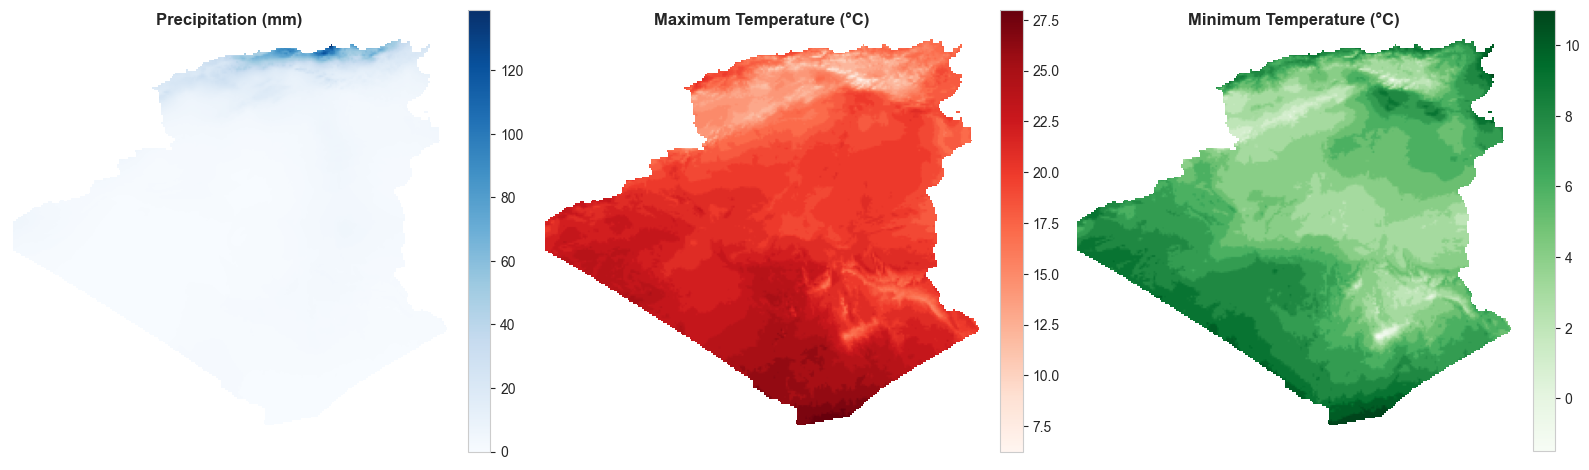

In [23]:

## 3.3 Climate Spatial Patterns

def visualize_climate_maps(prec, tmax, tmin):
    """Create spatial maps of climate variables."""
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    climate_data = [
        (prec, 'Precipitation (mm)', 'Blues'),
        (tmax, 'Maximum Temperature (°C)', 'Reds'),
        (tmin, 'Minimum Temperature (°C)', 'Greens')
    ]
    
    for ax, (data, title, cmap) in zip(axes, climate_data):
        im = ax.imshow(data, cmap=cmap)
        ax.set_title(title, fontweight='bold')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

visualize_climate_maps(prec, tmax, tmin)


In [24]:

## 3.4 Climate Variable Correlations

def climate_correlations(prec, tmax, tmin):
    """Analyze correlations between climate variables."""
    
    # Flatten and create valid mask
    prec_flat = prec.flatten()
    tmax_flat = tmax.flatten()
    tmin_flat = tmin.flatten()
    
    # Compute correlations
    correlations = []
    
    # Tmax - Tmin
    valid_mask = ~np.isnan(tmax_flat) & ~np.isnan(tmin_flat)
    corr_tmax_tmin = np.corrcoef(tmax_flat[valid_mask], tmin_flat[valid_mask])[0, 1]
    correlations.append(('Tmax - Tmin', corr_tmax_tmin))
    
    # Prec - Tmax
    valid_mask = ~np.isnan(prec_flat) & ~np.isnan(tmax_flat)
    corr_prec_tmax = np.corrcoef(prec_flat[valid_mask], tmax_flat[valid_mask])[0, 1]
    correlations.append(('Prec - Tmax', corr_prec_tmax))
    
    # Prec - Tmin
    valid_mask = ~np.isnan(prec_flat) & ~np.isnan(tmin_flat)
    corr_prec_tmin = np.corrcoef(prec_flat[valid_mask], tmin_flat[valid_mask])[0, 1]
    correlations.append(('Prec - Tmin', corr_prec_tmin))
    
    print("Climate Variable Correlations:")
    print("="*70)
    for pair, corr in correlations:
        print(f"  {pair}: {corr:.3f}")
    print("="*70)
    
    # Extreme value thresholds
    print("\nExtreme Value Thresholds:")
    print(f"  High Tmax (95th percentile): {np.nanpercentile(tmax, 95):.2f}°C")
    print(f"  Low Tmin (5th percentile): {np.nanpercentile(tmin, 5):.2f}°C")
    print(f"  High Prec (95th percentile): {np.nanpercentile(prec, 95):.2f} mm")

climate_correlations(prec, tmax, tmin)


Climate Variable Correlations:
  Tmax - Tmin: 0.650
  Prec - Tmax: -0.516
  Prec - Tmin: -0.060

Extreme Value Thresholds:
  High Tmax (95th percentile): 25.00°C
  Low Tmin (5th percentile): 2.75°C
  High Prec (95th percentile): 20.84 mm


## 4. Fire-Climate Integration

In [25]:

# Linking fire occurrences with climate conditions.

def integrate_fire_climate():
    """Extract climate values at fire locations."""
    
    # Load fire data
    fire = pd.read_csv("../data/processed/Fire/combined_fire_data_2024.csv")
    fire_gdf = gpd.GeoDataFrame(
        fire,
        geometry=gpd.points_from_xy(fire.longitude, fire.latitude),
        crs="EPSG:4326"
    )
    
    # Open climate rasters
    prec_ds = rasterio.open("../data/processed/Climate/wc2.1_cruts4.09_5m_prec_2024-01_clipped.tif")
    tmax_ds = rasterio.open("../data/processed/Climate/wc2.1_cruts4.09_5m_tmax_2024-01_clipped.tif")
    tmin_ds = rasterio.open("../data/processed/Climate/wc2.1_cruts4.09_5m_tmin_2024-01_clipped.tif")
    
    # Extract values at fire points
    coords = [(x, y) for x, y in zip(fire_gdf.geometry.x, fire_gdf.geometry.y)]
    
    fire_gdf['prec'] = [val[0] if val[0] != prec_ds.nodata else None 
                        for val in prec_ds.sample(coords)]
    fire_gdf['tmax'] = [val[0] if val[0] != tmax_ds.nodata else None 
                        for val in tmax_ds.sample(coords)]
    fire_gdf['tmin'] = [val[0] if val[0] != tmin_ds.nodata else None 
                        for val in tmin_ds.sample(coords)]
    
    print("✅ Climate values extracted at fire locations")
    print(f"Fire events with climate data: {fire_gdf[['prec', 'tmax', 'tmin']].notna().all(axis=1).sum()}")
    
    return fire_gdf

fire_gdf = integrate_fire_climate()
fire_gdf[['latitude', 'longitude', 'prec', 'tmax', 'tmin']].head()


✅ Climate values extracted at fire locations
Fire events with climate data: 90154


latitude  longitude        prec   tmax  tmin
0  27.72818    9.87200    1.900000  19.25  3.75
1  28.63288    9.77909    2.300000  18.00  2.00
2  28.64012    9.77953    2.300000  18.00  2.00
3  36.74886    6.25409  106.599998  15.25  7.75
4  35.87978    4.44782   18.600000  13.50  4.75

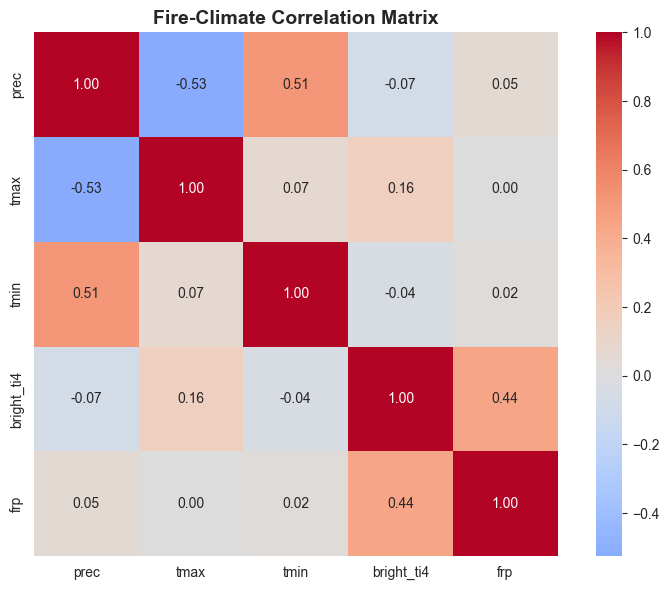

In [26]:

## 4.1 Fire-Climate Correlations

def fire_climate_correlations(fire_gdf):
    """Analyze correlations between fire and climate."""
    
    # Correlation matrix
    climate_fire_cols = ['prec', 'tmax', 'tmin', 'bright_ti4', 'frp']
    corr_matrix = fire_gdf[climate_fire_cols].corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, ax=ax)
    ax.set_title('Fire-Climate Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

fire_climate_correlations(fire_gdf)


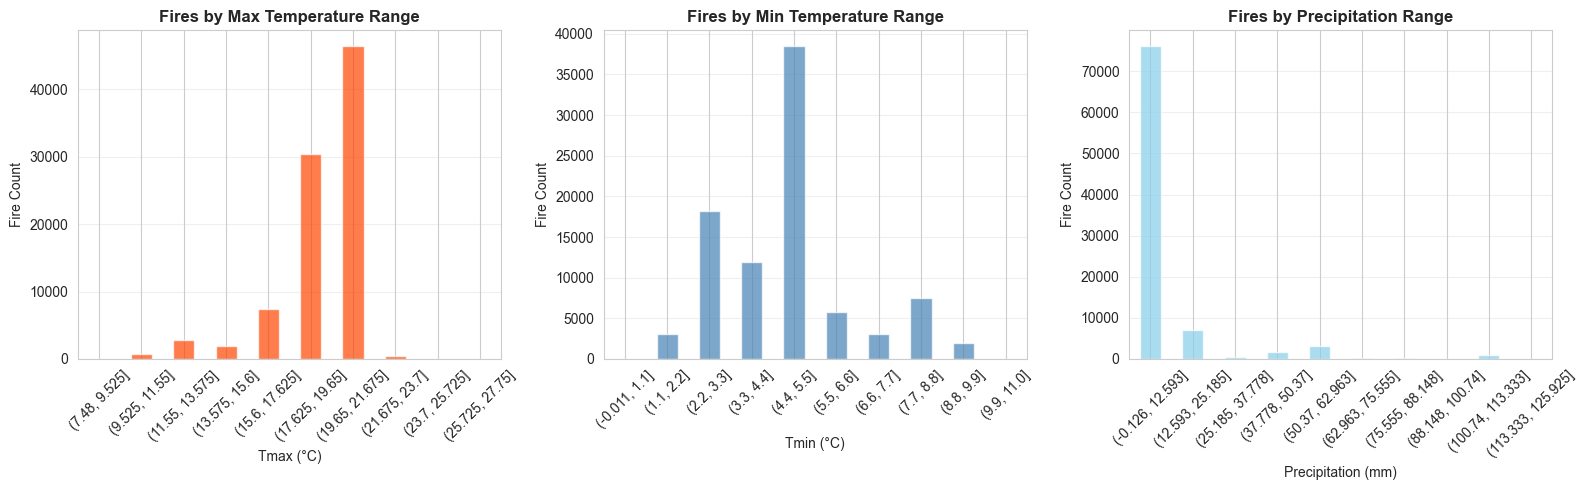

In [27]:

## 4.2 Fire Occurrence by Climate Conditions

def fire_by_climate_conditions(fire_gdf):
    """Analyze fire occurrence across climate ranges."""
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Fire by Tmax range
    fire_gdf['tmax_bin'] = pd.cut(fire_gdf['tmax'], bins=10)
    fire_gdf.groupby('tmax_bin').size().plot(kind='bar', ax=axes[0], color='orangered', alpha=0.7)
    axes[0].set_title('Fires by Max Temperature Range', fontweight='bold')
    axes[0].set_xlabel('Tmax (°C)')
    axes[0].set_ylabel('Fire Count')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Fire by Tmin range
    fire_gdf['tmin_bin'] = pd.cut(fire_gdf['tmin'], bins=10)
    fire_gdf.groupby('tmin_bin').size().plot(kind='bar', ax=axes[1], color='steelblue', alpha=0.7)
    axes[1].set_title('Fires by Min Temperature Range', fontweight='bold')
    axes[1].set_xlabel('Tmin (°C)')
    axes[1].set_ylabel('Fire Count')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Fire by Precipitation range
    fire_gdf['prec_bin'] = pd.cut(fire_gdf['prec'], bins=10)
    fire_gdf.groupby('prec_bin').size().plot(kind='bar', ax=axes[2], color='skyblue', alpha=0.7)
    axes[2].set_title('Fires by Precipitation Range', fontweight='bold')
    axes[2].set_xlabel('Precipitation (mm)')
    axes[2].set_ylabel('Fire Count')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

fire_by_climate_conditions(fire_gdf)


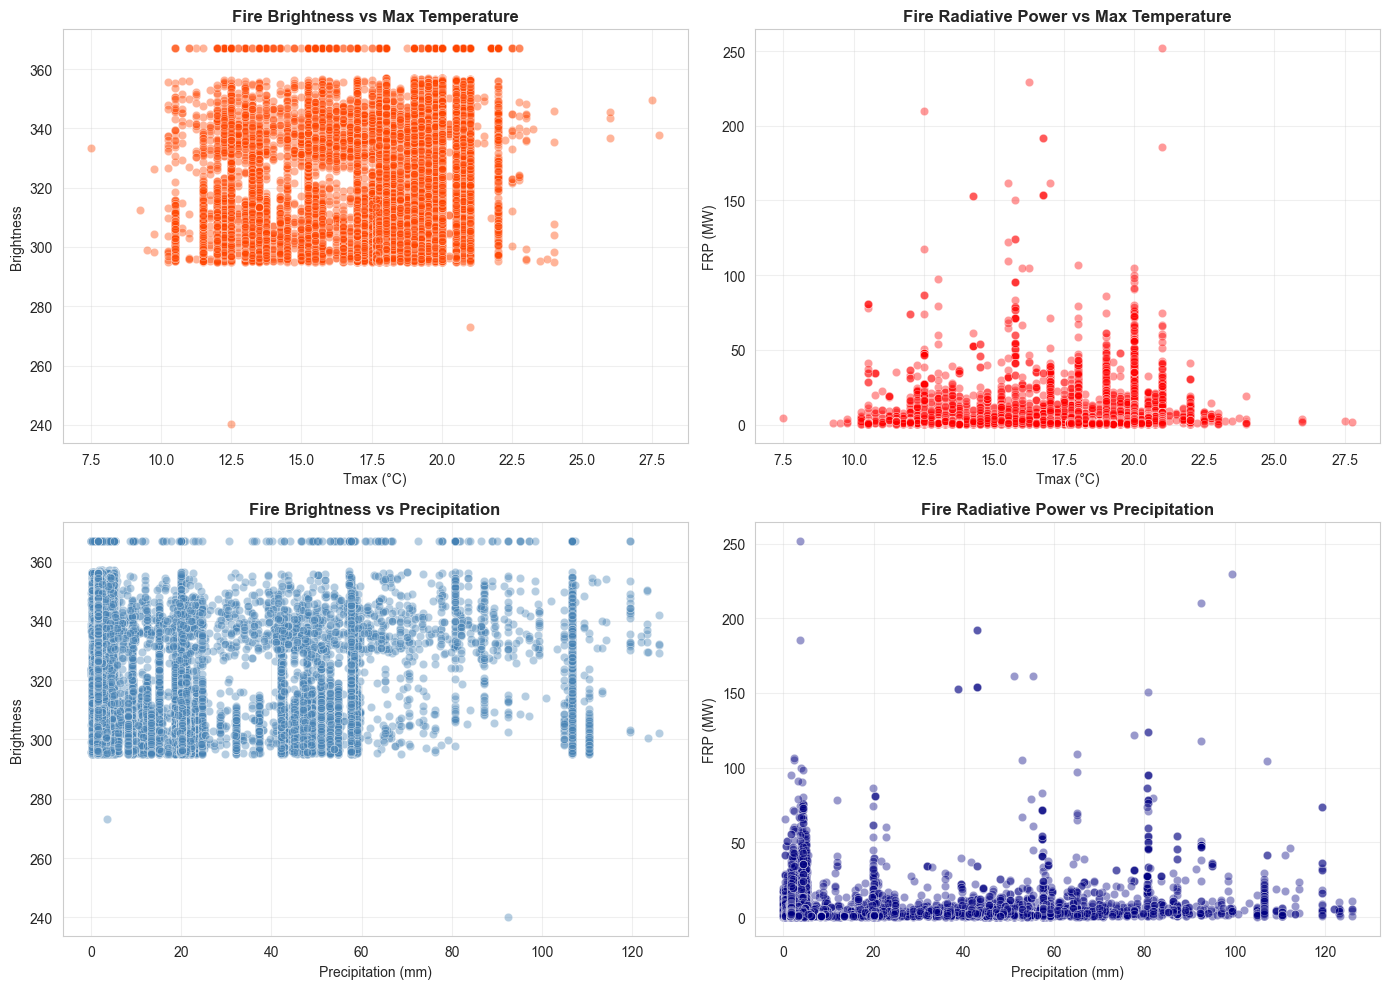

In [28]:

## 4.3 Scatter Plots: Fire vs Climate

def fire_climate_scatter(fire_gdf):
    """Create scatter plots of fire characteristics vs climate."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Brightness vs Tmax
    sns.scatterplot(data=fire_gdf, x='tmax', y='bright_ti4', alpha=0.4, 
                   color='orangered', ax=axes[0, 0])
    axes[0, 0].set_title('Fire Brightness vs Max Temperature', fontweight='bold')
    axes[0, 0].set_xlabel('Tmax (°C)')
    axes[0, 0].set_ylabel('Brightness')
    axes[0, 0].grid(True, alpha=0.3)
    
    # FRP vs Tmax
    sns.scatterplot(data=fire_gdf, x='tmax', y='frp', alpha=0.4, 
                   color='red', ax=axes[0, 1])
    axes[0, 1].set_title('Fire Radiative Power vs Max Temperature', fontweight='bold')
    axes[0, 1].set_xlabel('Tmax (°C)')
    axes[0, 1].set_ylabel('FRP (MW)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Brightness vs Precipitation
    sns.scatterplot(data=fire_gdf, x='prec', y='bright_ti4', alpha=0.4, 
                   color='steelblue', ax=axes[1, 0])
    axes[1, 0].set_title('Fire Brightness vs Precipitation', fontweight='bold')
    axes[1, 0].set_xlabel('Precipitation (mm)')
    axes[1, 0].set_ylabel('Brightness')
    axes[1, 0].grid(True, alpha=0.3)
    
    # FRP vs Precipitation
    sns.scatterplot(data=fire_gdf, x='prec', y='frp', alpha=0.4, 
                   color='navy', ax=axes[1, 1])
    axes[1, 1].set_title('Fire Radiative Power vs Precipitation', fontweight='bold')
    axes[1, 1].set_xlabel('Precipitation (mm)')
    axes[1, 1].set_ylabel('FRP (MW)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

fire_climate_scatter(fire_gdf)

## 5. Fire-Land Cover Integration

In [29]:

def integrate_fire_landcover(fire_gdf, landcover):
    """Spatial join of fire points with land cover polygons."""
    
    # Ensure same CRS
    if fire_gdf.crs != landcover.crs:
        fire_gdf = fire_gdf.to_crs(landcover.crs)
    
    # Spatial join
    fire_in_lc = gpd.sjoin(fire_gdf, landcover, how="inner", predicate="within")
    
    print("✅ Fire-Land Cover integration complete")
    print(f"Fire events matched to land cover: {len(fire_in_lc)}")
    
    # Fire counts by land cover type
    fire_counts = fire_in_lc.groupby("GRIDCODE").size().reset_index(name="fire_count")
    print("\nFire Counts by Land Cover Type:")
    print(fire_counts.sort_values('fire_count', ascending=False))
    
    return fire_in_lc

fire_in_lc = integrate_fire_landcover(fire_gdf, landcover)


✅ Fire-Land Cover integration complete
Fire events matched to land cover: 90058

Fire Counts by Land Cover Type:
    GRIDCODE  fire_count
14       201       36583
13       200       22876
15       202       17024
12       190        5254
3         30        2487
10       150        2366
2         20        1205
16       210         689
0         14         593
11       151         530
8        130         204
6        110         105
4         50          66
9        134          56
5         70          17
7        120           2
1         16           1


In [30]:
## 5.1 Climate Summary by Land Cover

def climate_by_landcover(fire_in_lc):
    """Aggregate climate statistics by land cover type."""
    
    climate_summary = fire_in_lc.groupby("GRIDCODE").agg(
        mean_tmax=("tmax", "mean"),
        mean_tmin=("tmin", "mean"),
        mean_prec=("prec", "mean"),
        fire_count=("GRIDCODE", "count")
    ).reset_index().sort_values('fire_count', ascending=False)
    
    print("Climate Summary by Land Cover Type:")
    print(climate_summary)
    
    return climate_summary

climate_summary = climate_by_landcover(fire_in_lc)


Climate Summary by Land Cover Type:
    GRIDCODE  mean_tmax  mean_tmin  mean_prec  fire_count
14       201  19.461922   3.824194   2.940958       36583
13       200  18.862413   4.712117   4.729675       22876
15       202  19.788549   5.356570   3.362820       17024
12       190  18.149797   8.205273  33.618866        5254
3         30  15.909450   7.052071  61.935589        2487
10       150  15.552163   5.985581  34.589367        2366
2         20  15.721967   6.023511  42.581547        1205
16       210  18.858530   8.547320  23.698328         689
0         14  16.674831   7.120777  48.773941         593
11       151  15.571496   5.311553  13.451184         530
8        130  15.209813   6.514805  65.093872         204
6        110  14.688095   4.442857  19.725954         105
4         50  14.878788   6.621212  77.216667          66
9        134  16.316965   6.892857  44.867859          56
5         70  16.470589   7.720588  60.527946          17
7        120  15.000000   7.625000  

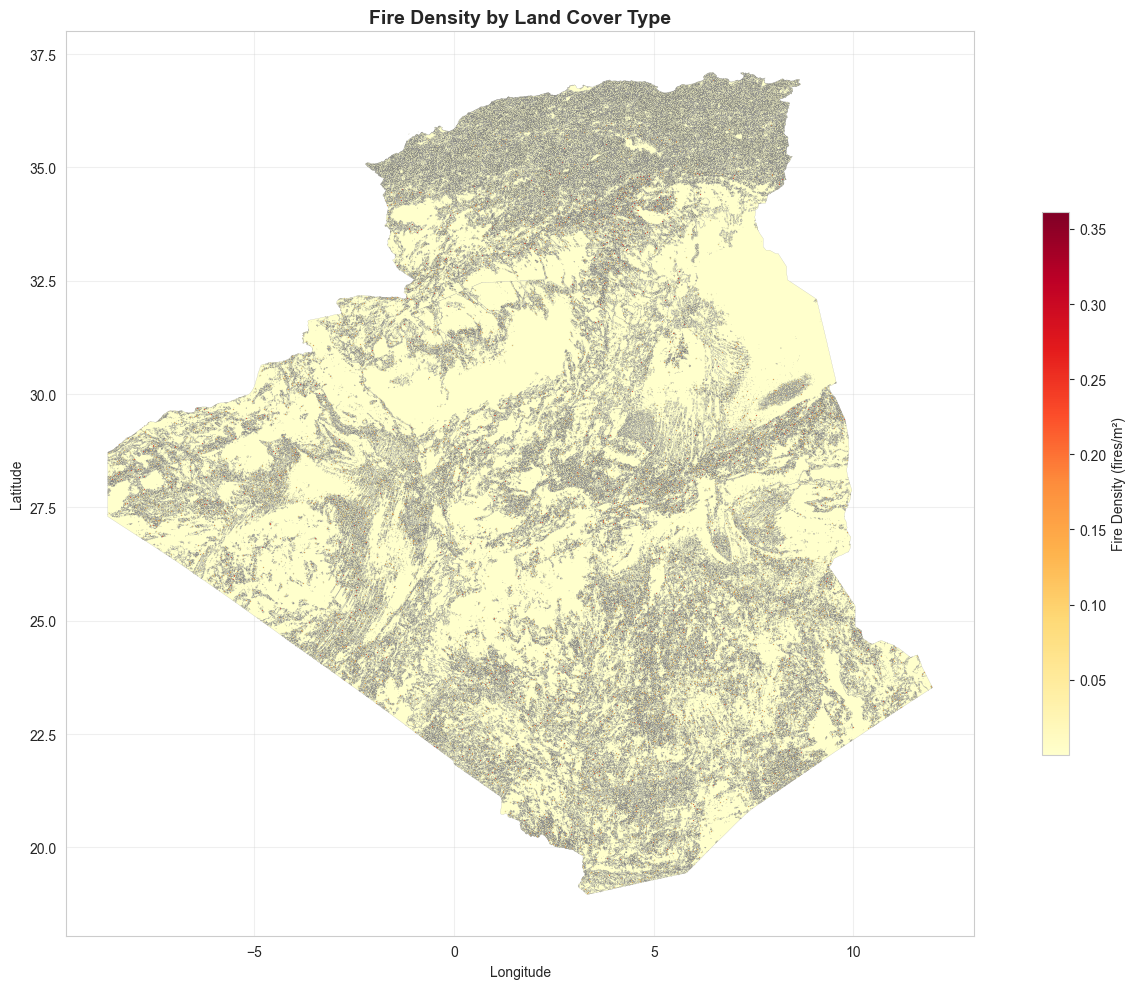

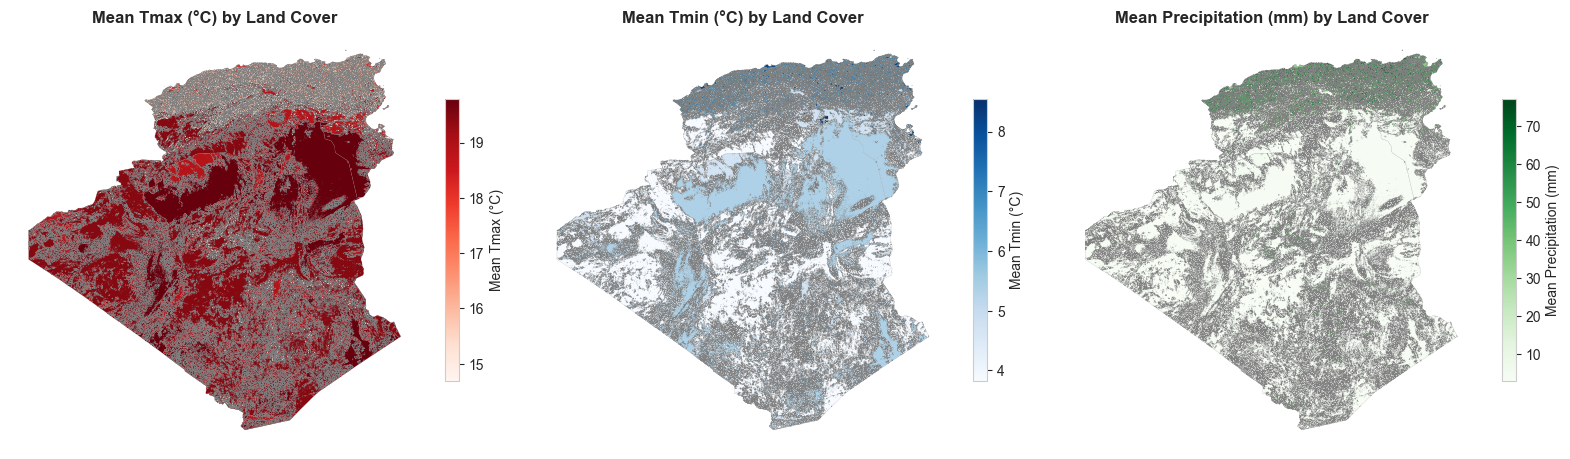

In [31]:
## 5.2 Fire Density by Land Cover

def visualize_fire_density(landcover, climate_summary):
    """Create fire density map by land cover type."""
    
    # Merge with landcover
    landcover_stats = landcover.merge(climate_summary, on="GRIDCODE", how="left")
    landcover_stats['fire_density'] = landcover_stats['fire_count'] / landcover_stats['AREA']
    
    # Fire density map
    fig, ax = plt.subplots(figsize=(14, 10))
    landcover_stats.plot(
        column="fire_density",
        ax=ax,
        cmap="YlOrRd",
        legend=True,
        edgecolor='gray',
        linewidth=0.1,
        legend_kwds={'label': 'Fire Density (fires/m²)', 'shrink': 0.6}
    )
    ax.set_title('Fire Density by Land Cover Type', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Climate maps
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for ax, col, title, cmap in zip(
        axes,
        ['mean_tmax', 'mean_tmin', 'mean_prec'],
        ['Mean Tmax (°C)', 'Mean Tmin (°C)', 'Mean Precipitation (mm)'],
        ['Reds', 'Blues', 'Greens']
    ):
        landcover_stats.plot(
            column=col,
            ax=ax,
            cmap=cmap,
            legend=True,
            edgecolor='gray',
            linewidth=0.1,
            legend_kwds={'label': title, 'shrink': 0.6}
        )
        ax.set_title(f'{title} by Land Cover', fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_fire_density(landcover, climate_summary)


## 6. Elevation Analysis

In [32]:
def analyze_elevation():
    """Load and analyze elevation data."""
    
    elev_path = "../data/processed/Elevation/elevation_clipped.tif"
    elev_ds = rasterio.open(elev_path)
    
    print("="*70)
    print("ELEVATION DATA OVERVIEW")
    print("="*70)
    print(f"CRS: {elev_ds.crs}")
    print(f"Shape: {elev_ds.shape}")
    print(f"Bounds: {elev_ds.bounds}")
    print("="*70)
    
    # Read data
    elev = elev_ds.read(1)
    elev = np.where(elev == elev_ds.nodata, np.nan, elev)
    
    # Statistics
    print("\nElevation Statistics:")
    print(f"  Min: {np.nanmin(elev):.2f} m")
    print(f"  Max: {np.nanmax(elev):.2f} m")
    print(f"  Mean: {np.nanmean(elev):.2f} m")
    print(f"  Std: {np.nanstd(elev):.2f} m")
    
    return elev_ds, elev

elev_ds, elev = analyze_elevation()


ELEVATION DATA OVERVIEW
CRS: EPSG:4326
Shape: (4461, 4958)
Bounds: BoundingBox(left=-8.675138888889023, bottom=18.958194444444377, right=11.983194444444297, top=37.545694444444365)

Elevation Statistics:
  Min: -872.00 m
  Max: 2877.00 m
  Mean: 538.56 m
  Std: 324.21 m


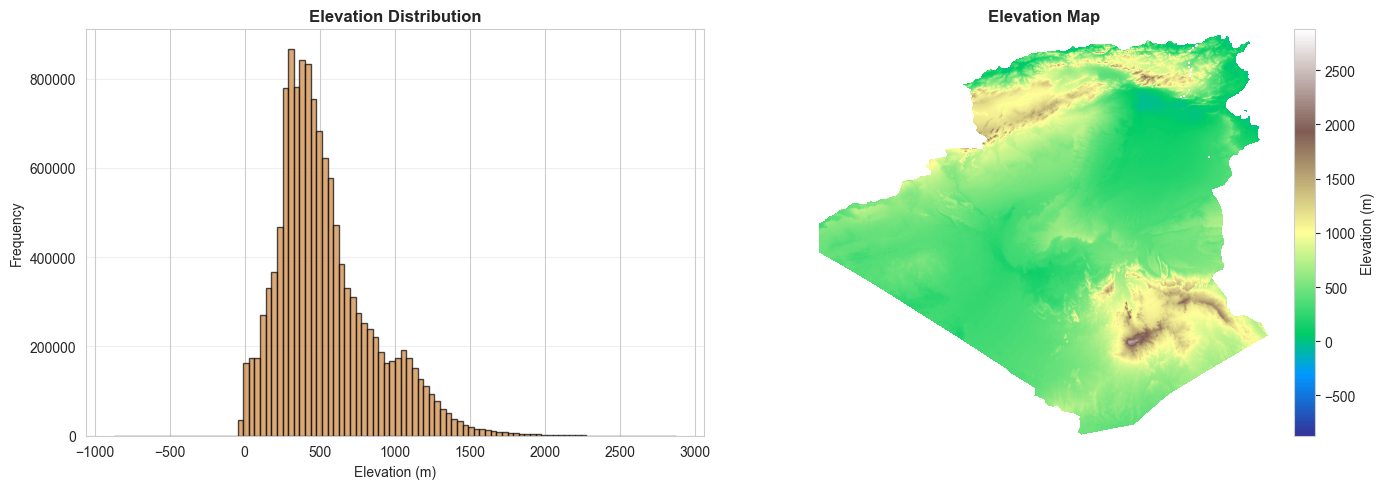

In [33]:
## 6.1 Elevation Distribution

def elevation_distribution(elev):
    """Visualize elevation distribution."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(elev.flatten(), bins=100, color='peru', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Elevation (m)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Elevation Distribution', fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Elevation map
    im = axes[1].imshow(elev, cmap='terrain')
    axes[1].set_title('Elevation Map', fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], label='Elevation (m)', fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

elevation_distribution(elev)


✅ Elevation values extracted at fire locations
Fire events with elevation data: 90144


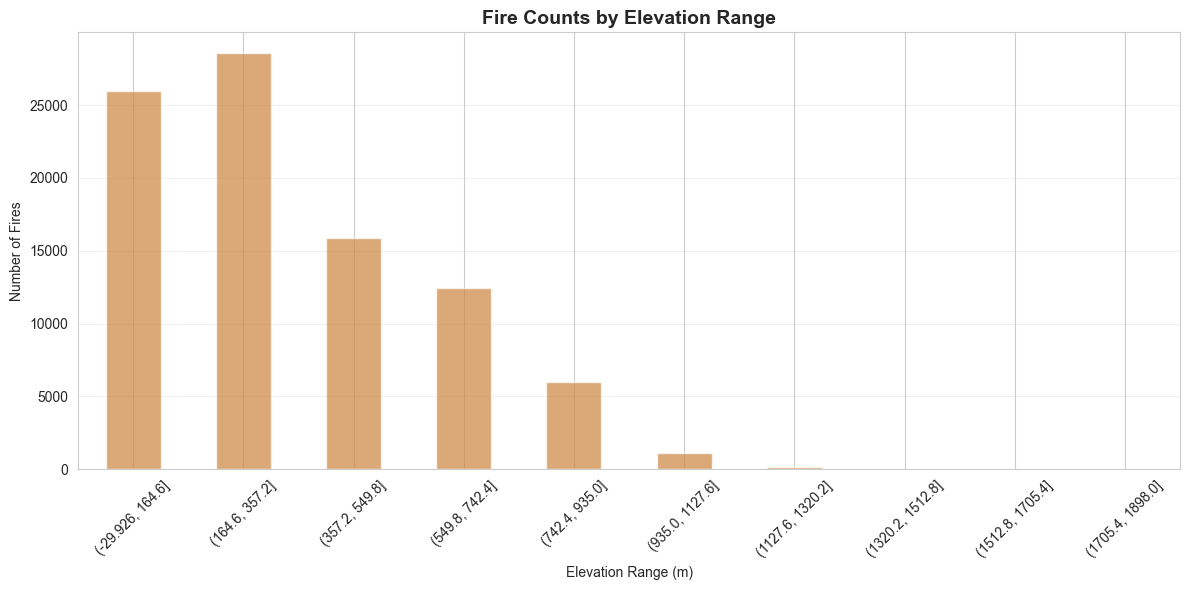

In [34]:

## 6.2 Fire-Elevation Integration

def integrate_fire_elevation(fire_gdf, elev_ds):
    """Extract elevation values at fire locations."""
    
    coords = [(x, y) for x, y in zip(fire_gdf.geometry.x, fire_gdf.geometry.y)]
    fire_gdf['elevation'] = [val[0] if val[0] != elev_ds.nodata else None 
                             for val in elev_ds.sample(coords)]
    
    print("✅ Elevation values extracted at fire locations")
    print(f"Fire events with elevation data: {fire_gdf['elevation'].notna().sum()}")
    
    # Fire by elevation range
    fire_gdf['elev_bin'] = pd.cut(fire_gdf['elevation'], bins=10)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    fire_gdf.groupby('elev_bin').size().plot(kind='bar', ax=ax, color='peru', alpha=0.7)
    ax.set_title('Fire Counts by Elevation Range', fontsize=14, fontweight='bold')
    ax.set_xlabel('Elevation Range (m)')
    ax.set_ylabel('Number of Fires')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return fire_gdf

fire_gdf = integrate_fire_elevation(fire_gdf, elev_ds)


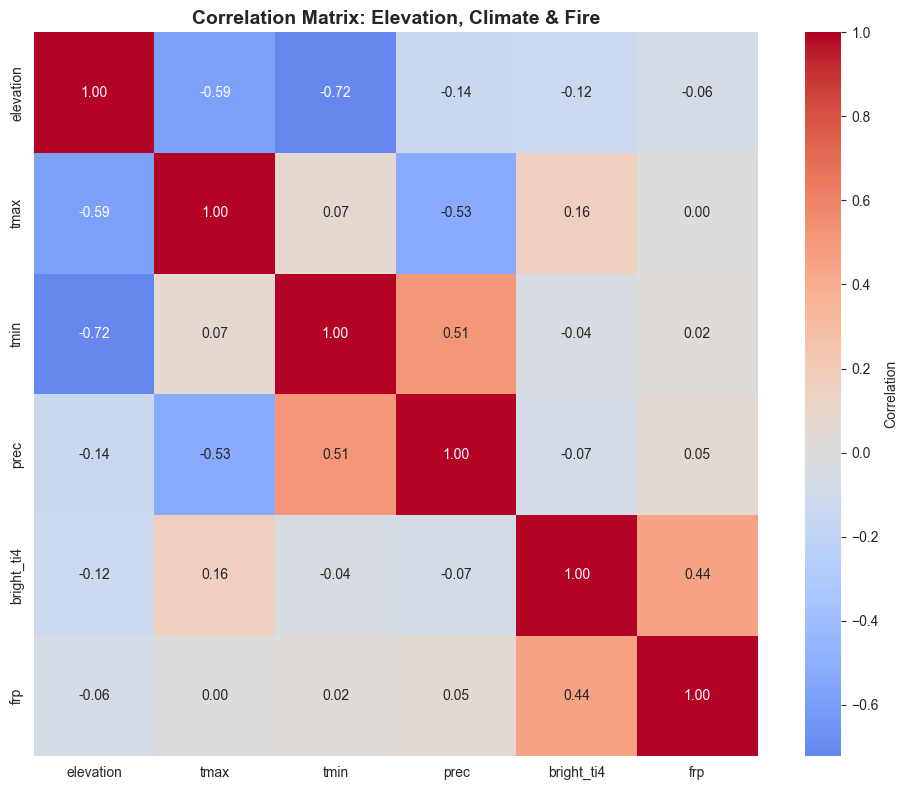

In [35]:
## 6.3 Elevation-Climate-Fire Correlations

def elevation_climate_fire_correlations(fire_gdf):
    """Analyze correlations including elevation."""
    
    cols = ['elevation', 'tmax', 'tmin', 'prec', 'bright_ti4', 'frp']
    corr_matrix = fire_gdf[cols].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('Correlation Matrix: Elevation, Climate & Fire', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

elevation_climate_fire_correlations(fire_gdf)


## 7. Soil Data Analysis

In [36]:

def analyze_soil_data():
    """Load and analyze soil data."""
    
    soil = pd.read_csv("../data/processed/Soil/soil_data_layers_filtered.csv")
    
    print("="*70)
    print("SOIL DATA OVERVIEW")
    print("="*70)
    print(f"Shape: {soil.shape}")
    print(f"\nColumns: {list(soil.columns)}")
    print(f"\nMissing Values:\n{soil.isnull().sum().sort_values(ascending=False)}")
    print("="*70)
    
    return soil

soil = analyze_soil_data()
soil.head()

SOIL DATA OVERVIEW
Shape: (58405, 23)

Columns: ['COARSE', 'SAND', 'SILT', 'CLAY', 'TEXTURE_USDA', 'TEXTURE_SOTER', 'BULK', 'REF_BULK', 'ORG_CARBON', 'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF', 'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND', 'ID']

Missing Values:
TEXTURE_USDA     1289
REF_BULK         1289
ORG_CARBON        672
COARSE              0
CEC_CLAY            0
ELEC_COND           0
GYPSUM              0
TCARBON_EQ          0
ESP                 0
ALUM_SAT            0
BSAT                0
TEB                 0
CEC_EFF             0
CN_RATIO            0
CEC_SOIL            0
SAND                0
TOTAL_N             0
PH_WATER            0
BULK                0
TEXTURE_SOTER       0
CLAY                0
SILT                0
ID                  0
dtype: int64


COARSE  SAND  SILT  CLAY  TEXTURE_USDA TEXTURE_SOTER  BULK  REF_BULK  \
0       5    67    18    15          11.0             C  1.35      1.63   
1       5    67    18    15          11.0             C  1.35      1.63   
2       5    67    18    15          11.0             C  1.35      1.63   
3       5    67    18    15          11.0             C  1.35      1.63   
4       2    24    52    24           7.0             M  1.44      1.76   

   ORG_CARBON  PH_WATER  TOTAL_N  CN_RATIO  CEC_SOIL  CEC_CLAY  CEC_EFF  TEB  \
0       1.062       6.3     0.77      13.0         8        46      6.0  5.0   
1       1.062       6.3     0.77      13.0         8        46      6.0  5.0   
2       1.062       6.3     0.77      13.0         8        46      6.0  5.0   
3       1.062       6.3     0.77      13.0         8        46      6.0  5.0   
4       1.475       5.2     1.03      10.0         9        20      6.0  4.0   

   BSAT  ALUM_SAT  ESP  TCARBON_EQ  GYPSUM  ELEC_COND   ID  
0    59         0    2         0.0     0.1          1  667  
1    59         0    2         0.0     0.1          1  668  
2    59         0    2         0.0     0.1          1  669  
3    59         0    2         0.0     0.1          1  670  
4    41        50    2         0.0     0.1          0  695

In [37]:
## 7.1 Soil Property Statistics

def soil_statistics(soil):
    """Display descriptive statistics for soil properties."""
    
    print("Soil Property Statistics:")
    print(soil.describe().T)

soil_statistics(soil)

Soil Property Statistics:
                count           mean            std     min         25%  \
COARSE        58405.0      11.184573       8.437106   -9.00       4.000   
SAND          58405.0      46.051879      17.348953   -9.00      36.000   
SILT          58405.0      30.209023      11.973649   -9.00      23.000   
CLAY          58405.0      21.282664      10.549217   -9.00      16.000   
TEXTURE_USDA  57116.0       8.602581       2.500621    3.00       7.000   
BULK          58405.0       1.226432       0.863178   -9.00       1.290   
REF_BULK      57116.0       1.707009       0.161498    0.97       1.650   
ORG_CARBON    57733.0       2.706419       6.243177   -9.00       0.711   
PH_WATER      58405.0       6.396850       1.924548   -9.00       5.700   
TOTAL_N       58405.0       1.720019       2.559947   -9.00       0.800   
CN_RATIO      58405.0      11.511412       3.993419   -9.00      10.000   
CEC_SOIL      58405.0      17.711720      14.348210   -9.00      11.000   

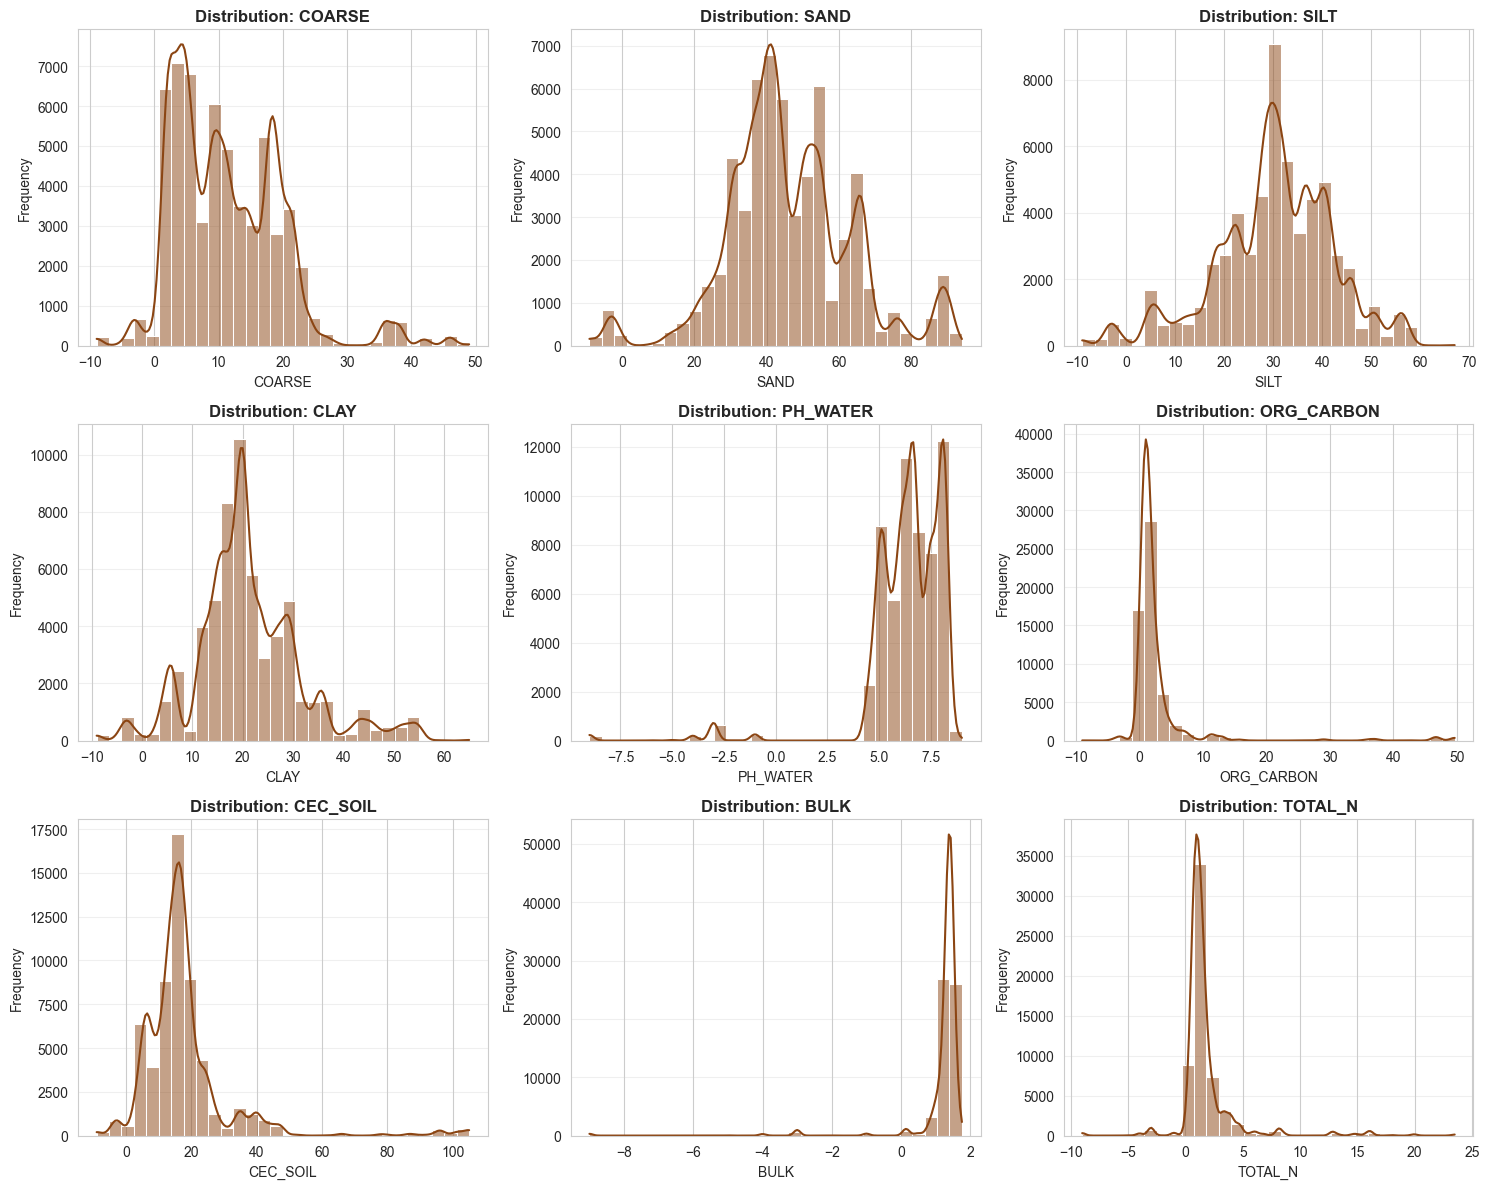

In [38]:
## 7.2 Soil Property Distributions

def soil_distributions(soil):
    """Visualize distributions of key soil properties."""
    
    key_properties = ['COARSE', 'SAND', 'SILT', 'CLAY', 'PH_WATER', 
                      'ORG_CARBON', 'CEC_SOIL', 'BULK', 'TOTAL_N']
    
    n_cols = 3
    n_rows = (len(key_properties) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
    axes = axes.flatten()
    
    for idx, prop in enumerate(key_properties):
        sns.histplot(soil[prop].dropna(), bins=30, kde=True, ax=axes[idx], color='saddlebrown')
        axes[idx].set_title(f'Distribution: {prop}', fontweight='bold')
        axes[idx].set_xlabel(prop)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(key_properties), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

soil_distributions(soil)


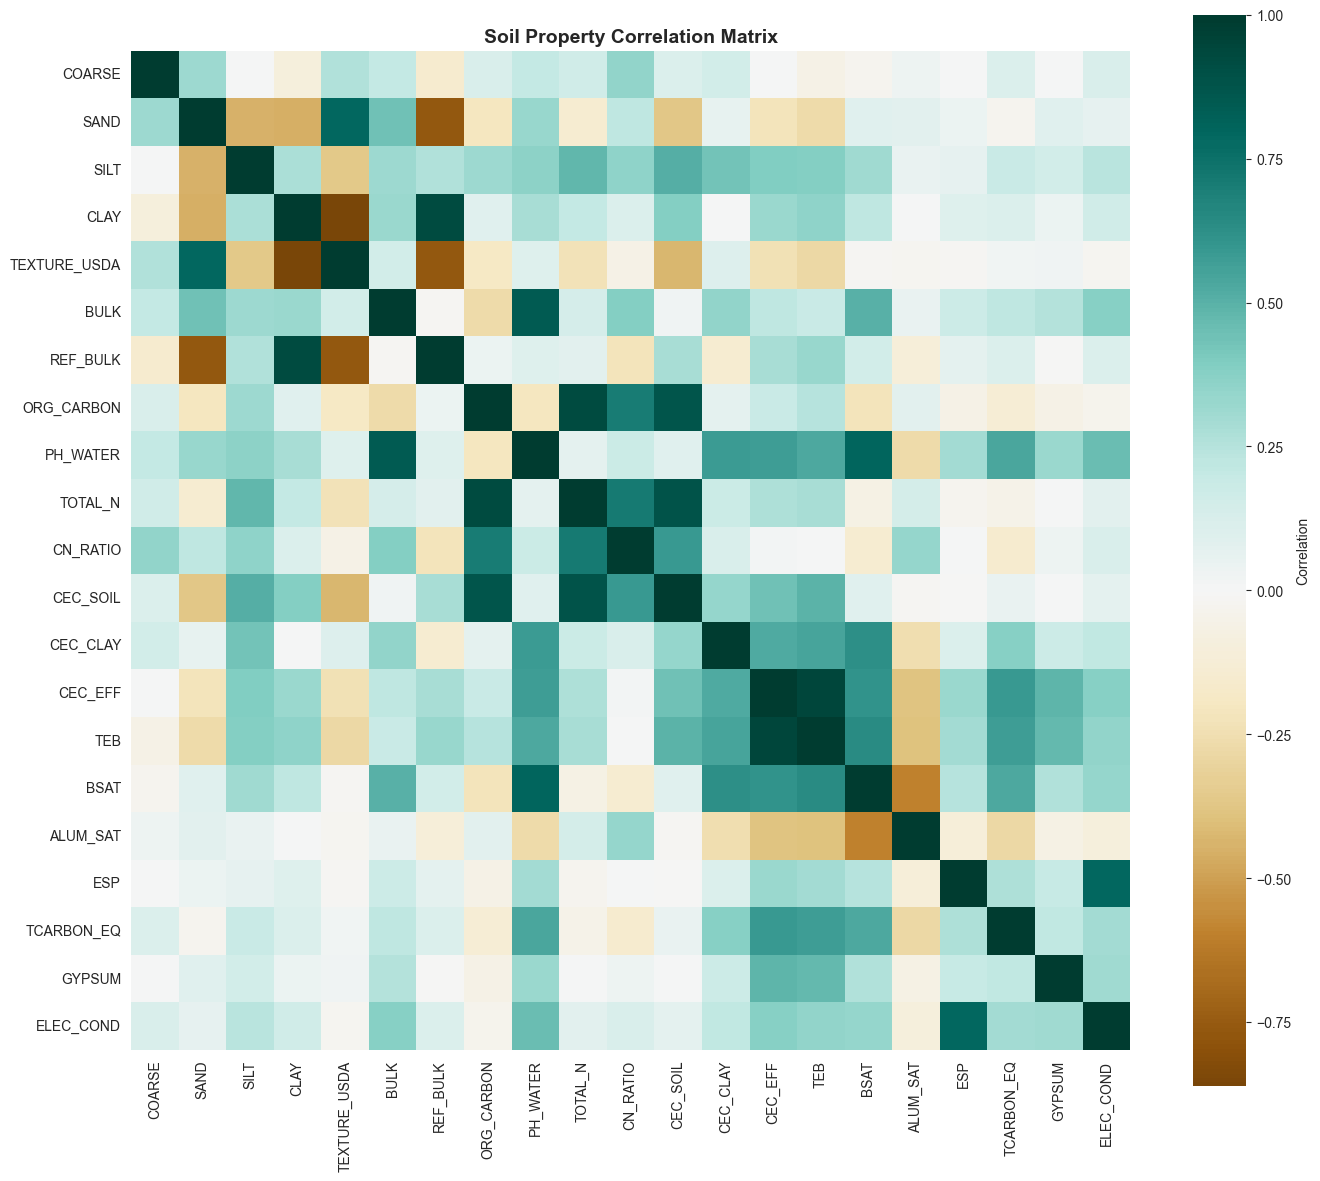

In [39]:
## 7.3 Soil Property Correlations

def soil_correlations(soil):
    """Analyze correlations between soil properties."""
    
    # Select numerical columns
    numeric_cols = soil.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'ID']
    
    corr_matrix = soil[numeric_cols].corr()
    
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=False, cmap='BrBG', center=0, 
                square=True, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('Soil Property Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

soil_correlations(soil)


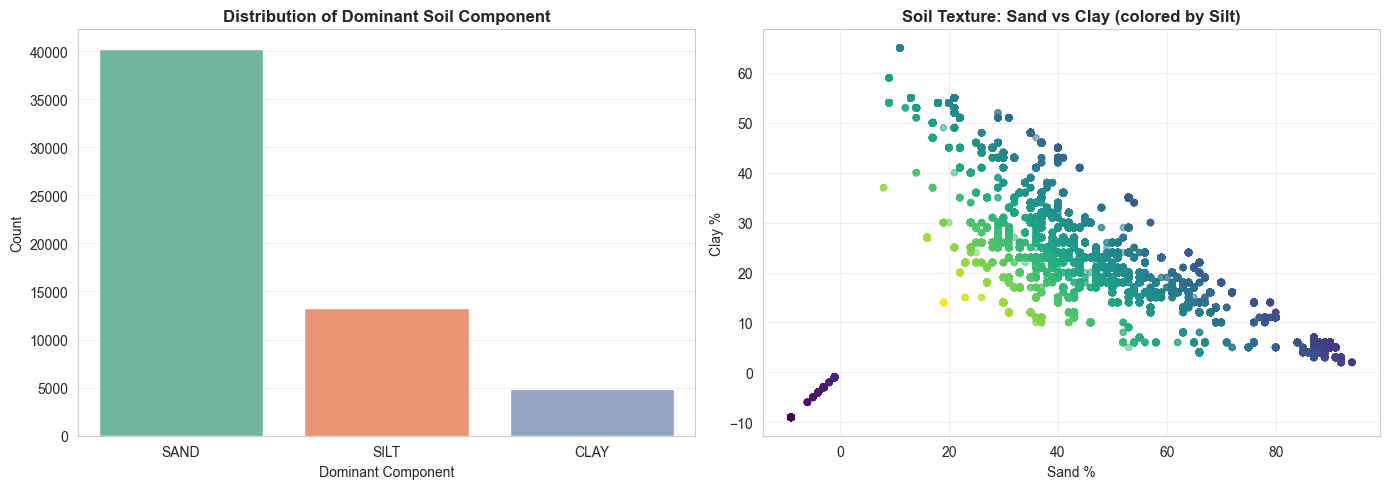

In [40]:
## 7.4 Soil Texture Analysis

def soil_texture_analysis(soil):
    """Analyze soil texture composition."""
    
    # Dominant texture component
    soil['Dominant_Texture'] = soil[['SAND', 'SILT', 'CLAY']].idxmax(axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot
    sns.countplot(data=soil, x='Dominant_Texture', ax=axes[0], 
                 palette='Set2', order=['SAND', 'SILT', 'CLAY'])
    axes[0].set_title('Distribution of Dominant Soil Component', fontweight='bold')
    axes[0].set_xlabel('Dominant Component')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Ternary-like visualization (simplified)
    axes[1].scatter(soil['SAND'], soil['CLAY'], c=soil['SILT'], 
                   cmap='viridis', alpha=0.5, s=20)
    axes[1].set_xlabel('Sand %')
    axes[1].set_ylabel('Clay %')
    axes[1].set_title('Soil Texture: Sand vs Clay (colored by Silt)', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

soil_texture_analysis(soil)
